# 0.0 IMPORTS

## 0.1 packages

In [1]:
import os, pickle, inflection, datetime, math
import pandas as pd
import numpy as np
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
import scipy.stats as ss


from sklearn.preprocessing              import RobustScaler,MinMaxScaler
from sklearn.base                       import BaseEstimator, TransformerMixin
from sklearn.preprocessing              import LabelEncoder
from sklearn.compose                    import TransformedTargetRegressor
from IPython.display                    import Image
from sklearn.linear_model               import LinearRegression, Lasso
from sklearn.ensemble                   import RandomForestRegressor
from sklearn.metrics                    import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from boruta                             import BorutaPy
#from sklearn.pipeline                   import Pipeline
#from kaggle.api.kaggle_api_extended     import KaggleApi


pd.options.display.max_columns = 500 # this will set limit of columns to 500
%matplotlib inline
os.getcwd()

p:\Anaconda3\envs\automl\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


'p:\\Python\\GitHub\\forecast_sales'

## 0.2 helper classes

In [2]:
class filtrator(BaseEstimator, TransformerMixin):
    def __init__(self,mapper_in=None,mapper_out=None):
        self.mapper_in=mapper_in
        self.mapper_out=mapper_out
        return None
    
    def fit(self, X, y=None):
        return self  # nothing else to do
    
    def transform(self,X):
        X2=X.copy()
        if self.mapper_in !=None:
            for k,v in self.mapper_in.items():
                X2=X2[X2[k].isin(v)]
        else: pass
        if self.mapper_out !=None:
            for k,v in self.mapper_out.items():
                X2=X2[~X2[k].isin(v)]
        pass
        return X2

In [3]:
class cols_selector(BaseEstimator, TransformerMixin):
    def __init__(self,sel=None,drop=None):
        self.sel=sel
        self.drop=drop
        return None
    
    def fit(self, X, y=None):
        return self  # nothing else to do
    
    def transform(self,X):
        if self.sel !=None:
            X2=X.copy()
            X2=X2[self.sel]
        else:
            X2=X.copy()
            X2=X2.drop(self.drop,axis=1)
        return X2

In [4]:
class dtypes(BaseEstimator, TransformerMixin):
    def __init__(self,dict_cols=None):
        self.dict_cols=dict_cols
        return None
    
    def fit(self, X, y=None):
        return self  # nothing else to do
    
    def transform(self,X):
        X2=X.copy()
        for k,v in self.dict_cols.items():
            X2[k]=X2[k].astype(v)
        return X2

## 0.3 helper funcions 

In [5]:
def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

In [6]:
def errors_ml(ytrue=None,ypred=None,model_name=None):
    mae_baseline=mean_absolute_error((ytrue),(ypred))
    mape_baseline=mean_absolute_percentage_error((ytrue),(ypred))
    mse_baseline=mean_squared_error((ytrue),(ypred))
    rmse_baseline=np.sqrt(mse_baseline)
    results=pd.DataFrame(data={'model_name':model_name,'MAE':mae_baseline,'MAPE':mape_baseline,'MSE':mse_baseline,'RMSE':rmse_baseline }, index=[0])
    return results

In [7]:
def cross_validation( x_training, kfold, model_name, model, verbose=False ):
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed( range( 1, kfold+1 ) ):
        if verbose:
            print( '\nKFold Number: {}'.format( k ) )
        # start and end date for validation 
        validation_start_date = x_training['date'].max() - datetime.timedelta( days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta( days=(k-1)*6*7)

        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # training and validation dataset
        # training
        xtraining = training.drop( ['date', 'sales'], axis=1 ) 
        ytraining = training['sales']

        # validation
        xvalidation = validation.drop( ['date', 'sales'], axis=1 )
        yvalidation = validation['sales']

        # model
        m = model.fit( xtraining, ytraining )

        # prediction
        yhat = m.predict( xvalidation )

        # performance
        m_result = errors_ml( ytrue=yvalidation ,  ypred=yhat  ,model_name=model_name   )




        # store performance of each kfold iteration
        mae_list.append(  m_result['MAE'] )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )

    return pd.DataFrame( {'Model Name': model_name,
                          'MAE CV': np.round( np.mean( mae_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mae_list ), 2 ).astype( str ),
                          'MAPE CV': np.round( np.mean( mape_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list ), 2 ).astype( str ),
                          'RMSE CV': np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2 ).astype( str ) }, index=[0] )

In [8]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['axes.formatter.limits'] = -20, +20
    plt.rcParams['figure.figsize'] = [30, 16]
    plt.rcParams['font.size'] = 24
    
    #display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )

    sns.set()

jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## 0.4 data import

In [9]:
train=pd.read_csv(r"data/train.csv",parse_dates=['Date'])
test=pd.read_csv(r"data/test.csv",parse_dates=['Date'])
store=pd.read_csv("data/store.csv")
train.head(1)


C:\Users\kosmo\AppData\Local\Temp\ipykernel_20708\4152312229.py:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train=pd.read_csv(r"data/train.csv",parse_dates=['Date'])


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1


In [10]:
df0=train.merge(store,how='left',on='Store',validate='many_to_one')
assert train.shape[0]==df0.shape[0]
df0.head(1)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN


# 1.0 DATA DESCRIPTION

## 1.1 rename columns

In [15]:
df1=df0.copy()
cols_old=df1.columns
snakecase = lambda x: inflection.underscore(x)
cols_new = list ( map( snakecase, cols_old))

#rename
df1.columns = cols_new
df1.head(1)

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN


## 1.2 data dimensions

In [16]:
df1.shape

(1017209, 18)

## 1.3 data types

In [17]:
df1.dtypes.sort_values()

store                                    int64
promo2                                   int64
promo                                    int64
open                                     int64
school_holiday                           int64
sales                                    int64
date                            datetime64[ns]
day_of_week                              int64
customers                                int64
promo2_since_year                      float64
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2_since_week                      float64
state_holiday                           object
store_type                              object
assortment                              object
promo_interval                          object
dtype: object

## 1.4 check NA

In [18]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 fillout NA

In [19]:
df1['competition_distance'].max()

75860.0

In [20]:
#competition_distance | It was assumed that NaN entries refers to far distance, let's say, 200000 which is higher than the max value of 75860
df1['competition_distance'] = df1['competition_distance'].apply( lambda x:200000.0 if math.isnan( x ) else x )


#competition_open_since_month | It was assumed that stores with no competition_open_since_month opened in the same sale month
df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1 )


#competition_open_since_year | It was assumed that stores with no competition_open_since_year opened in the same sale year
df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1 )

#promo2_since_week
df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan(x['promo2_since_week'] ) else x['promo2_since_week'], axis=1 )

#promo2_since_year
df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan(x['promo2_since_year'] ) else x['promo2_since_year'], axis=1 )



#promo_interval | It was assumed that stores with no promo_interval had no promo in fact
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',7: 'Jul', 8: 'Aug', 9: 'Sept', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
df1['promo_interval'].fillna(0, inplace=True )
df1['month_map'] = df1['date'].dt.month.map( month_map )
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 \
    if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 )

df1.head()


,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,31.0,2015.0,0,Jul,0
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",Jul,1
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",Jul,1
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,31.0,2015.0,0,Jul,0
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,31.0,2015.0,0,Jul,0


In [21]:
for i in ["competition_open_since_month","competition_open_since_year","promo2_since_week","promo2_since_year"]:
    df1[i]=df1[i].astype(int)

## 1.6 descriptive statistics

In [22]:
num_cols=df1.select_dtypes(include=['int64','float64'])
num_cols.agg(["mean","median","std","min","max","skew","kurtosis"]).T


,mean,median,std,min,max,skew,kurtosis
store,558.429727,558.0,321.908651,1.0,1115.0,-0.000955,-1.200524
day_of_week,3.998341,4.0,1.997391,1.0,7.0,0.001593,-1.246873
sales,5773.818972,5744.0,3849.926175,0.0,41551.0,0.641460,1.778375
customers,633.145946,609.0,464.411734,0.0,7388.0,1.598650,7.091773
open,0.830107,1.0,0.375539,0.0,1.0,-1.758045,1.090723
promo,0.381515,0.0,0.485759,0.0,1.0,0.487838,-1.762018
school_holiday,0.178647,0.0,0.383056,0.0,1.0,1.677842,0.815154
competition_distance,5935.442677,2330.0,12547.652996,20.0,200000.0,10.242344,147.789712
promo2,0.500564,1.0,0.500000,0.0,1.0,-0.002255,-1.999999
is_promo,0.171835,0.0,0.377237,0.0,1.0,1.739838,1.027039


## 1.7 describe sales per categoric attributes

In [23]:
cat_cols=df1.select_dtypes(include='object')
cat_cols.nunique()

state_holiday      5
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

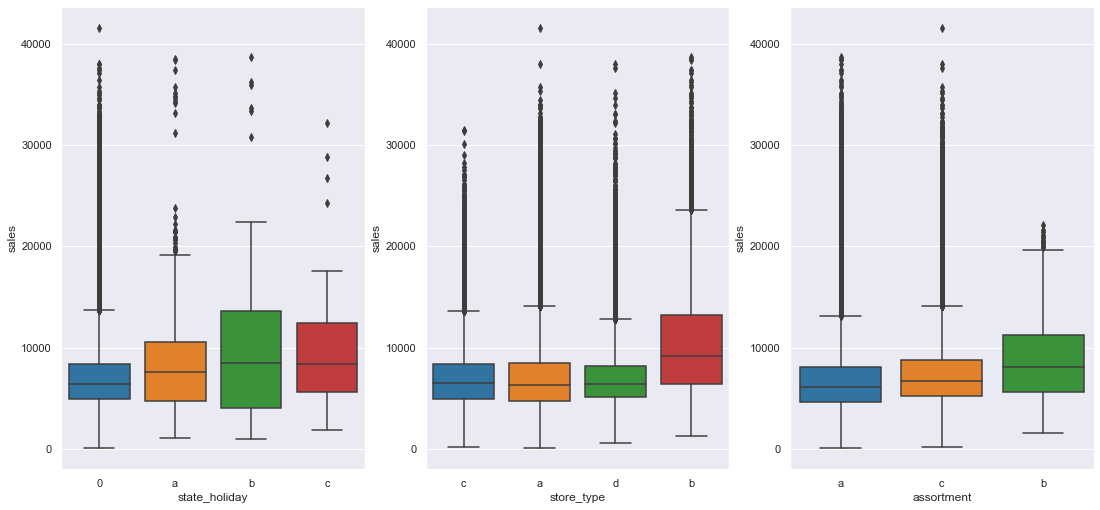

In [24]:
mask1=(df1['state_holiday']!=0) & (df1['sales']>0)
plt.subplot(1,3,1)
sns.boxplot(x='state_holiday',y='sales',data=df1[mask1],palette='tab10')

plt.subplot(1,3,2)
sns.boxplot(x='store_type',y='sales',data=df1[mask1],palette='tab10')

plt.subplot(1,3,3)
sns.boxplot(x='assortment',y='sales',data=df1[mask1],palette='tab10')


fig = plt.gcf()
fig.set_size_inches(18.5, 8.5)

# 2.0 FEATURE ENGINEERING

## 2.1 hypotesis mapping

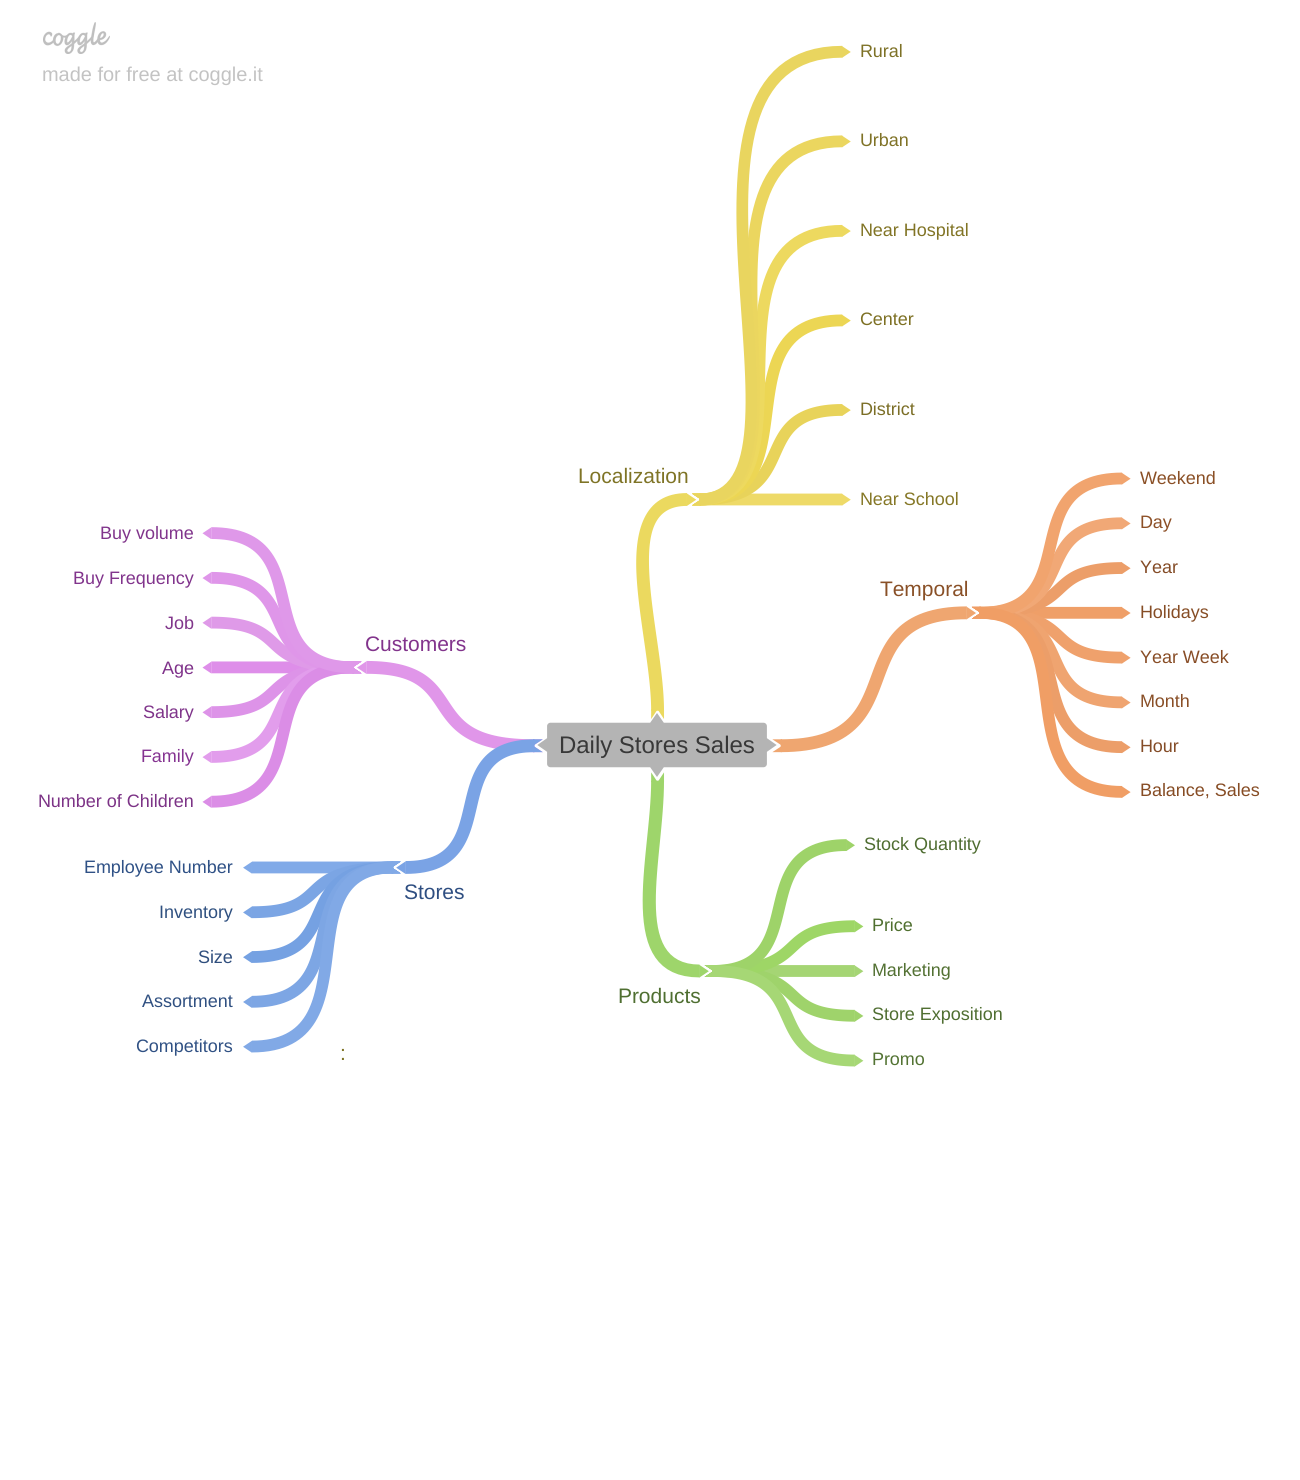

In [25]:
Image('img/Daily_Stores_Sales.png')

## 2.2 hypotesis list

In [26]:
df2=df1.copy()

## 2.3 feature creation

In [27]:

# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

# year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

# competition since
df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'],day=1 ), axis=1 )
df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30 ).apply( lambda x: x.days ).astype( int )

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days ).astype( int )

# assortment
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )

C:\Users\kosmo\AppData\Local\Temp\ipykernel_2832\799493721.py:11: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df2['week_of_year'] = df2['date'].dt.weekofyear


# 3.0 FEATURE FILTERING

In [28]:
df3=df2.copy()

## 3.1 row filtering

In [29]:
#only open stores and with at least one sale
df3=df3[(df3['open']!=0) & (df3['sales']>0)]

## 3.2 cols filtering

In [30]:
#we can't use these variables in production
cols_drop = ['customers','open','promo_interval','month_map']
df3=df3.drop(cols_drop,axis=1)

# 4.0 EXPLORATORY DATA ANALYSIS

In [31]:
df4=df3.copy()

## 4.1 univariate analysis

p:\Anaconda3\envs\kaggle\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


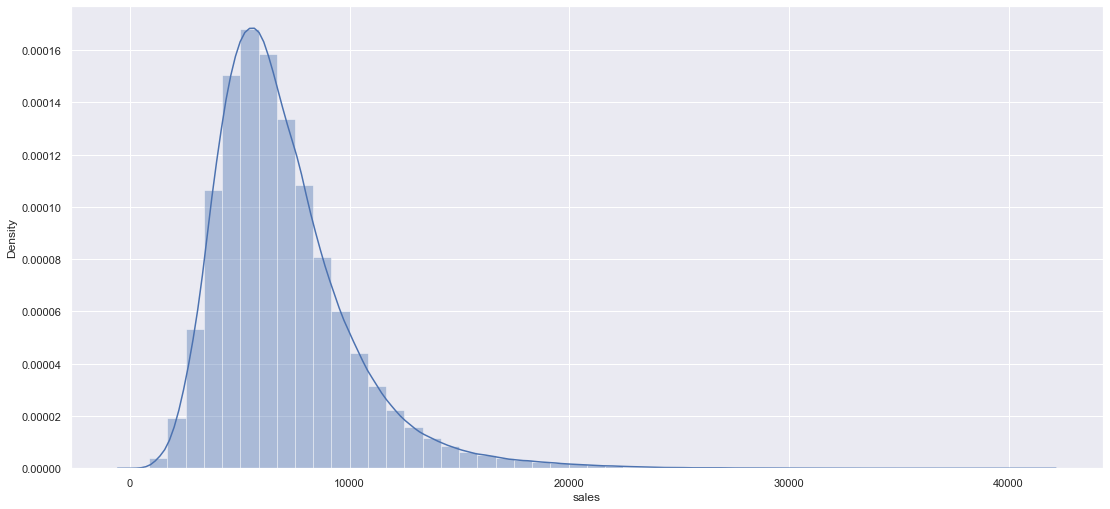

In [28]:
sns.distplot(df4['sales'])
fig = plt.gcf()
fig.set_size_inches(18.5, 8.5)


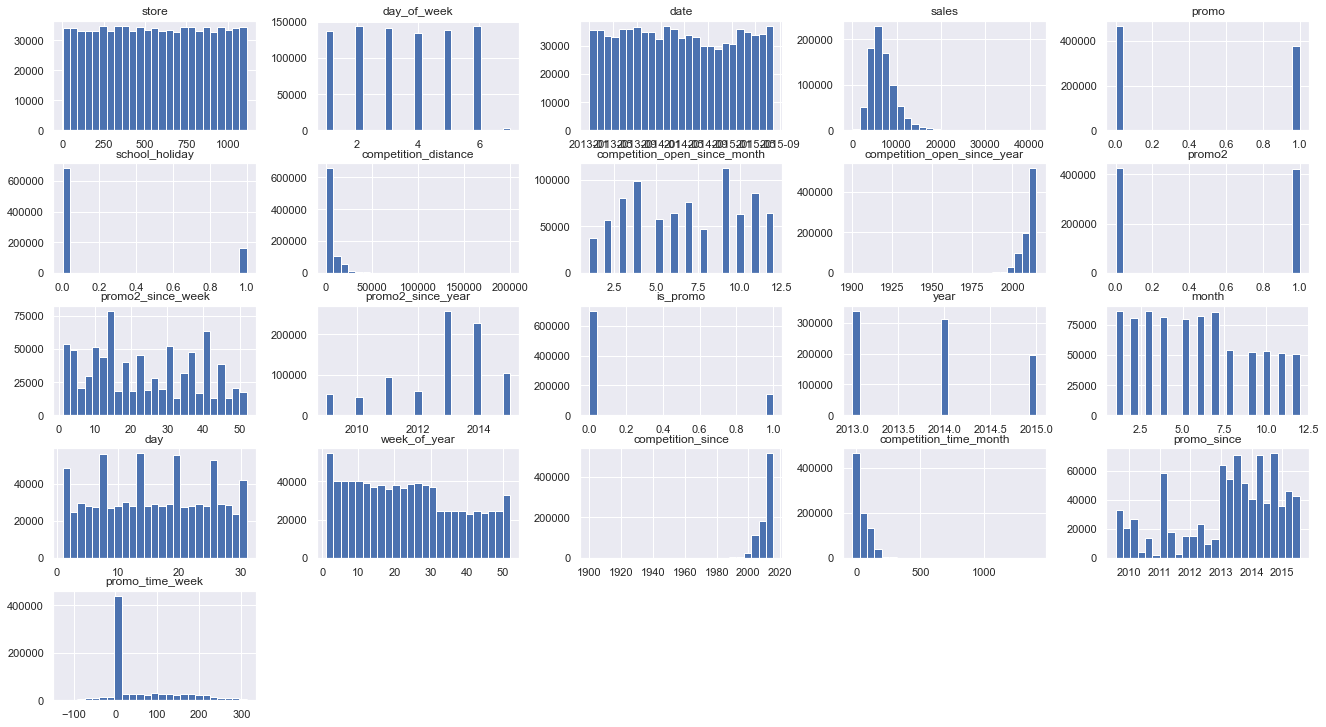

In [29]:
df4.hist(bins=25)
fig = plt.gcf()
fig.set_size_inches(22.5, 12.5)

p:\Anaconda3\envs\kaggle\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
p:\Anaconda3\envs\kaggle\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
p:\Anaconda3\envs\kaggle\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


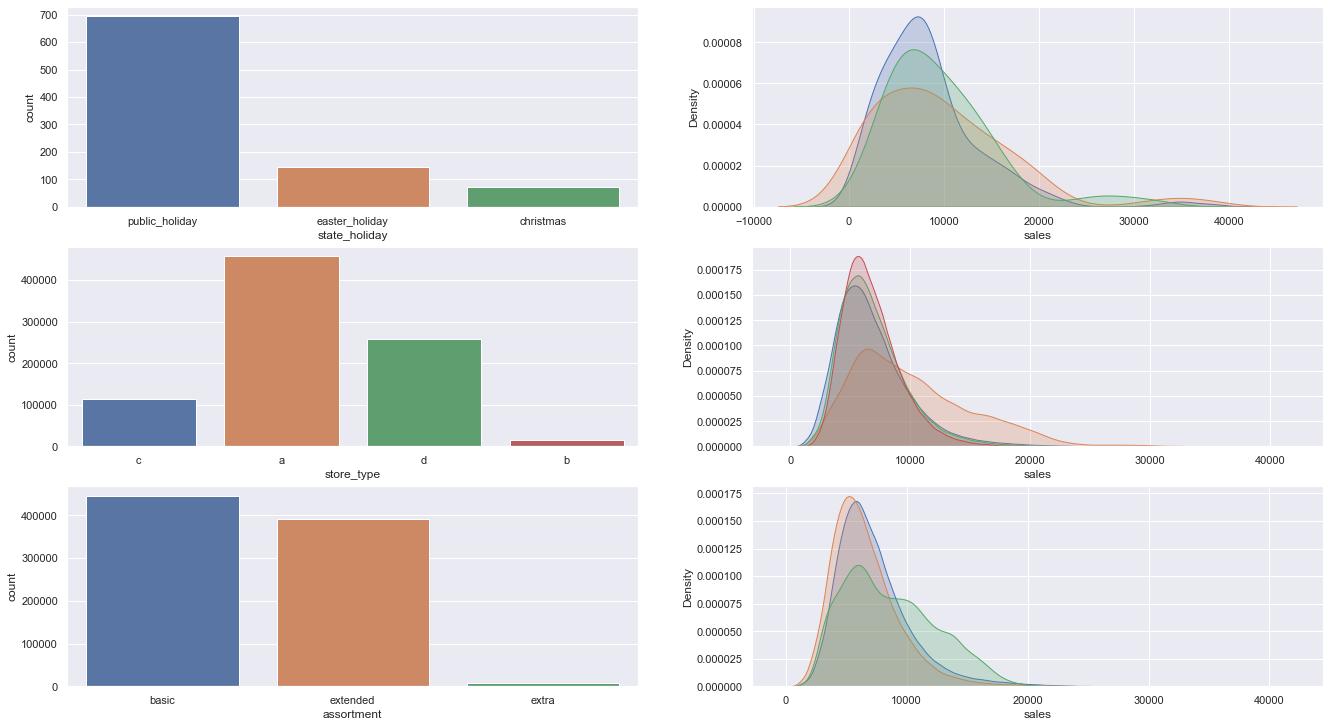

In [30]:
# state_holiday
plt.subplot( 3, 2, 1 )
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot( a['state_holiday'] )

plt.subplot( 3, 2, 2 )
sns.kdeplot( df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True )
sns.kdeplot( df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True )
sns.kdeplot( df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True )

# store_type
plt.subplot( 3, 2, 3 )
sns.countplot(df4['store_type'] )

plt.subplot( 3, 2, 4 )
sns.kdeplot( df4[df4['store_type'] == 'a']['sales'], label='a', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'b']['sales'], label='b', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'c']['sales'], label='c', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'd']['sales'], label='d', shade=True )

# assortment
plt.subplot( 3, 2, 5 )
sns.countplot( df4['assortment'] )

plt.subplot( 3, 2, 6 )
sns.kdeplot( df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True )
sns.kdeplot( df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True )
sns.kdeplot( df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True )

fig = plt.gcf()
fig.set_size_inches(22.5, 12.5)

## 4.2 bivariate analysis and hypoteses testing

### H1. Stores with larger assortments should sell more.
### **FALSE** Stores with larger assortment sell less

<AxesSubplot:xlabel='year_week'>

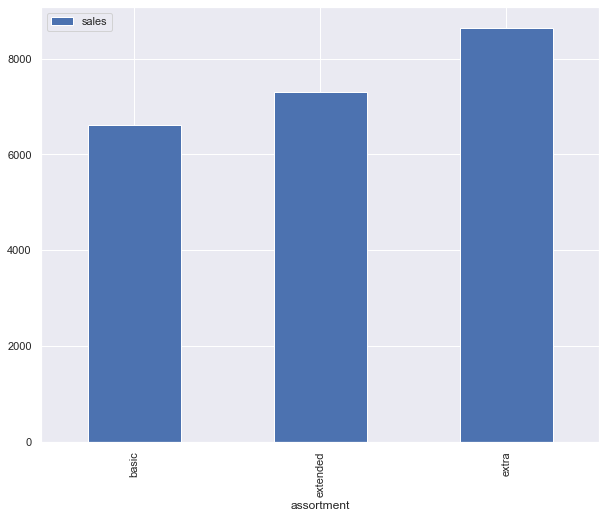

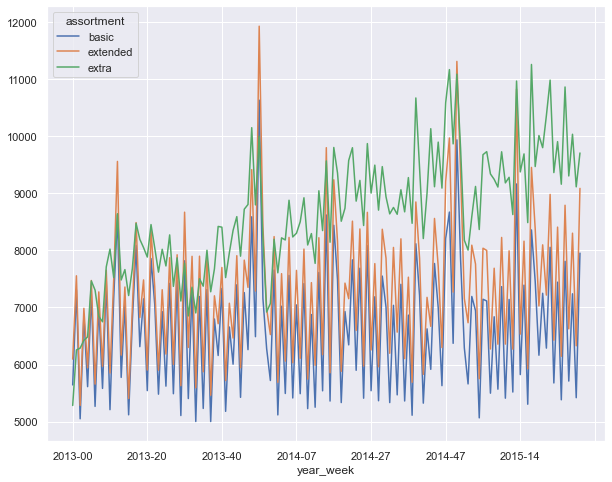

In [31]:
sns.set(rc={'figure.figsize':(10,8)})

df4.pivot_table(index='assortment',values='sales',aggfunc='mean').plot(kind='bar')

aux2 = df4[['year_week', 'assortment', 'sales']].groupby( ['year_week','assortment'] ).mean().reset_index()
aux2.pivot( index='year_week', columns='assortment', values='sales' ).plot()

### H2. Stores with closer competitors should sell less.
### **FALSE** Stores with CLOSER COMPETITORS sell MORE

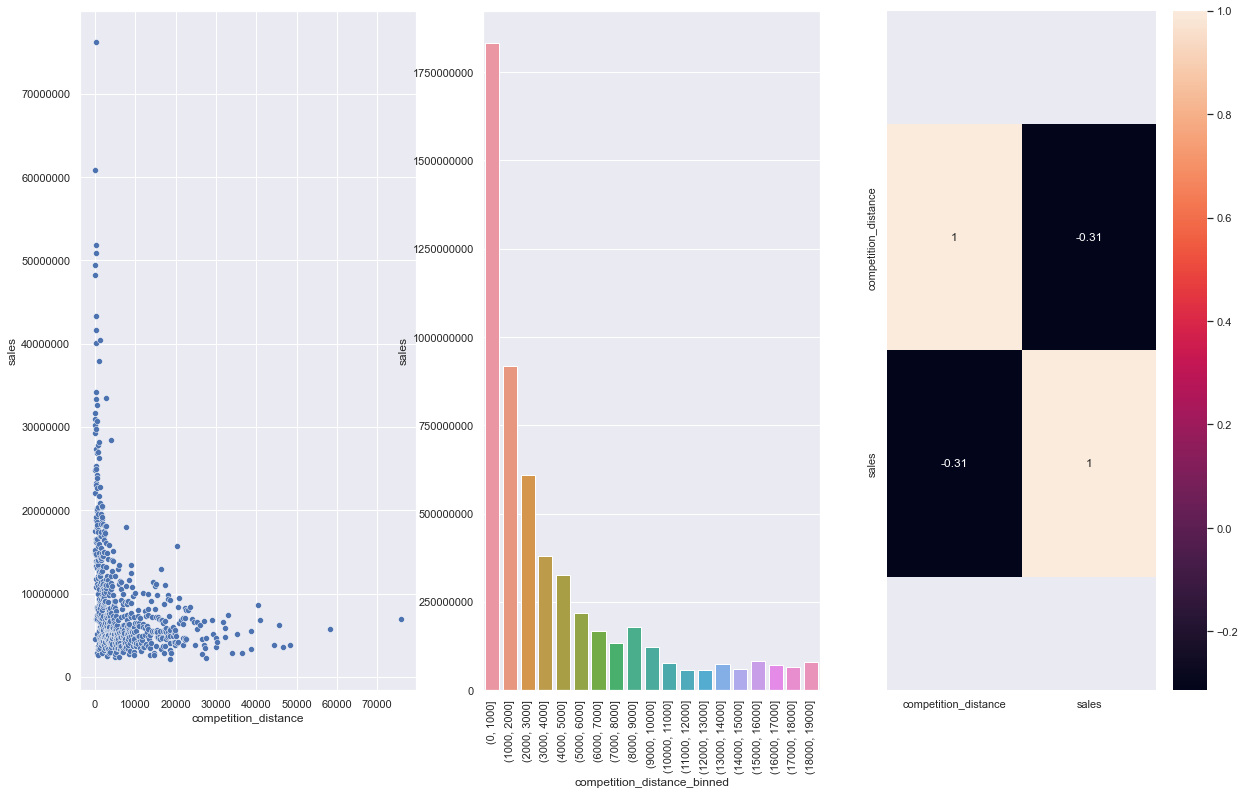

In [32]:
aux1 = df4[['competition_distance', 'sales']].groupby( 'competition_distance' ).sum().reset_index()
aux1=aux1[aux1['competition_distance']<150000]


plt.subplot( 1, 3, 1 )
sns.scatterplot( x ='competition_distance', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
bins = list( np.arange( 0, 20000, 1000) )
aux1['competition_distance_binned'] = pd.cut( aux1['competition_distance'], bins=bins )
aux2 = aux1[['competition_distance_binned', 'sales']].groupby( 'competition_distance_binned' ).sum().reset_index()
sns.barplot( x='competition_distance_binned', y='sales', data=aux2 );
plt.xticks( rotation=90 );

plt.subplot( 1, 3, 3 )
x = sns.heatmap( aux1.corr( method='pearson' ), annot=True );
bottom, top = x.get_ylim()
x.set_ylim( bottom+0.5, top-0.5 );

fig = plt.gcf()
fig.set_size_inches(20.5, 12.5)

### **H3.** Store with longer competitors should sell less
### **FALSE** Stores with LONGER COMPETITORS sell less

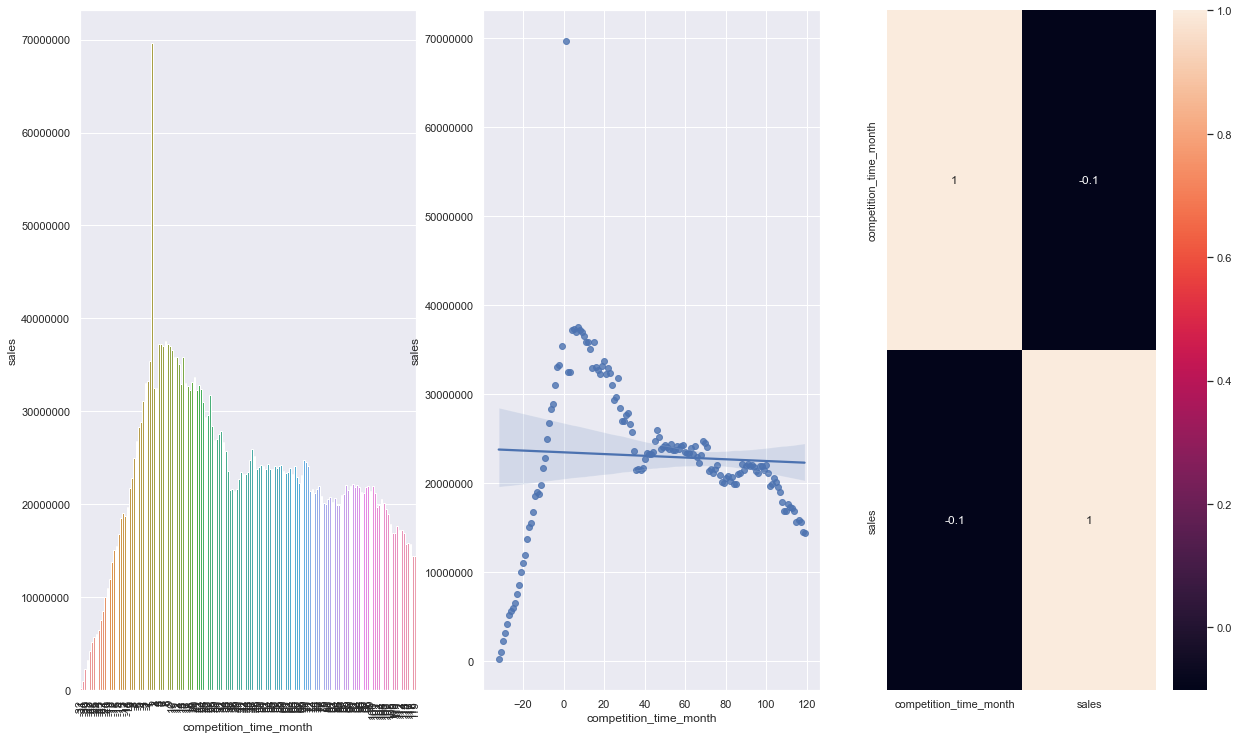

In [166]:
plt.subplot( 1, 3, 1 )
aux1 = df4[['competition_time_month', 'sales']].groupby( 'competition_time_month' ).sum().reset_index()
aux2 = aux1[( aux1['competition_time_month'] < 120 ) & ( aux1['competition_time_month'] != 0 )]
sns.barplot( x='competition_time_month', y='sales', data=aux2 )
plt.xticks( rotation=90 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='competition_time_month', y='sales', data=aux2 )

plt.subplot( 1, 3, 3 )
x = sns.heatmap( aux1.corr( method='pearson'), annot=True )
plt.xticks( rotation=0 );


fig = plt.gcf()
fig.set_size_inches(20.5, 12.5)

### **H4.** Stores with longer promotions should sell more.
### **FALSE** Stores with longer promotion sell less, after a certain period

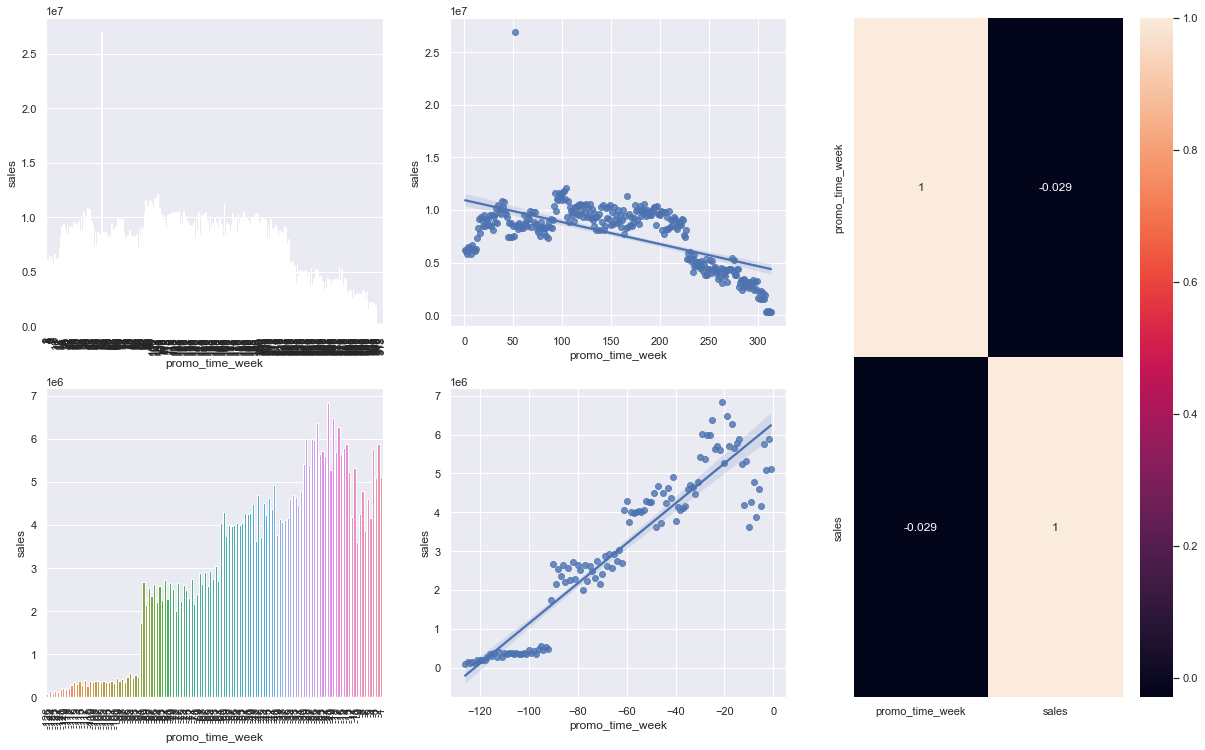

In [35]:
aux1 = df4[['promo_time_week', 'sales']].groupby( 'promo_time_week').sum().reset_index()

from matplotlib import gridspec

grid = gridspec.GridSpec( 2, 3 )

plt.subplot( grid[0,0] )
aux2 = aux1[aux1['promo_time_week'] > 0] # promo extendido
sns.barplot( x='promo_time_week', y='sales', data=aux2 );
plt.xticks( rotation=90 );

plt.subplot( grid[0,1] )
sns.regplot( x='promo_time_week', y='sales', data=aux2 );

plt.subplot( grid[1,0] )
aux3 = aux1[aux1['promo_time_week'] < 0] # promo regular
sns.barplot( x='promo_time_week', y='sales', data=aux3 );
plt.xticks( rotation=90 );

plt.subplot( grid[1,1] )
sns.regplot( x='promo_time_week', y='sales', data=aux3 );

plt.subplot( grid[:,2] )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

fig = plt.gcf()
fig.set_size_inches(20.5, 12.5)

### <s>**H5.** Stores with more promotions days should sell more </s>
### We haven't the promotions quantity information, therefore we will not test it in this first circle of CRISP-PM.

### <s>**H6.** Stores with more agressive promotion should sell more </s>
### We haven't the promotions discount information, therefore we will not test it in this first circle of CRISP-PM.

### **H7.** Stores with more consecutives promotions should sell more
### **FALSE** Stores with more consecutives promotions sell less

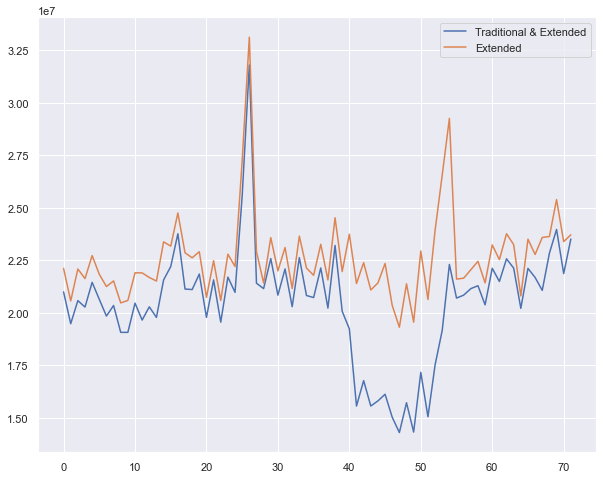

In [36]:
aux1 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 1 )][['year_week', 'sales']].groupby( 'year_week' ).sum().reset_index()
ax = aux1.plot()

aux2 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 0 )][['year_week', 'sales']].groupby( 'year_week' ).sum().reset_index()
aux2.plot( ax=ax )

ax.legend( labels=['Traditional & Extended', 'Extended']);

### H8 Stores open on Christmas Holiday should sell more.

###  **FALSE** Stores open on christmas holiday sell less.

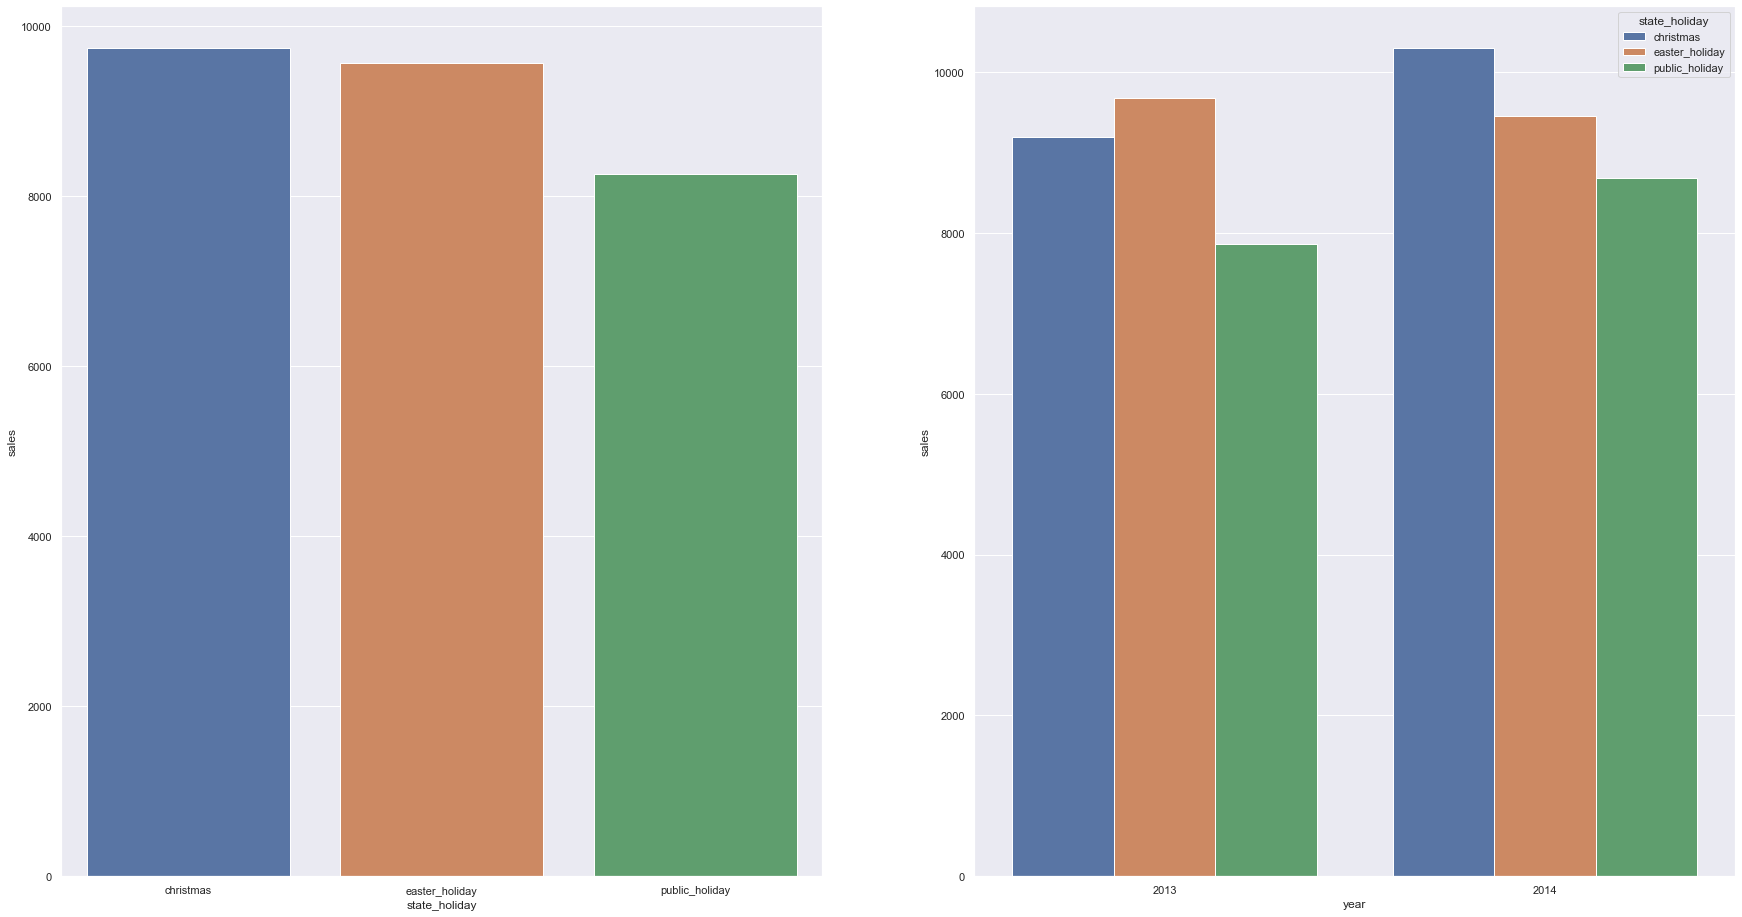

In [140]:
aux = df4[(df4['state_holiday'] != 'regular_day') & (df4['year']<2015)]

plt.subplot( 1, 2, 1 )
aux1 = aux[['state_holiday', 'sales']].groupby( 'state_holiday' ).mean().reset_index()
sns.barplot( x='state_holiday', y='sales', data=aux1 );

plt.subplot( 1, 2, 2 )
aux2 = aux[['year', 'state_holiday', 'sales']].groupby( ['year', 'state_holiday'] ).mean().reset_index()
sns.barplot( x='year', y='sales', hue='state_holiday', data=aux2 );


### H9. Stores should sell more over the years.
###  **FALSE** Stores sell less over the years

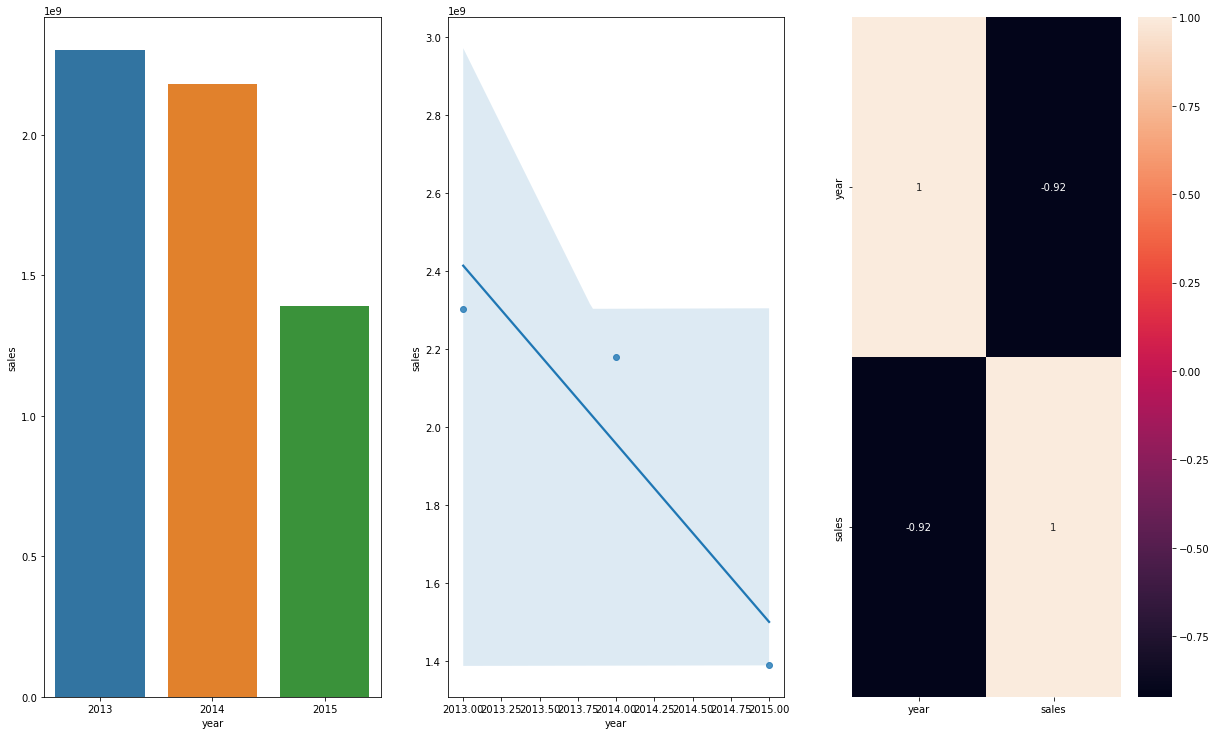

In [135]:
aux1 = df4[['year', 'sales']].groupby( 'year' ).sum().reset_index()

plt.subplot( 1, 3, 1)
sns.barplot( x='year', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='year', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );
plt.gcf().set_size_inches(20.5,12.5)

### H10 Stores should sell more in the second half of the year.
###  **FALSE** Stores sell less in the second half of the year

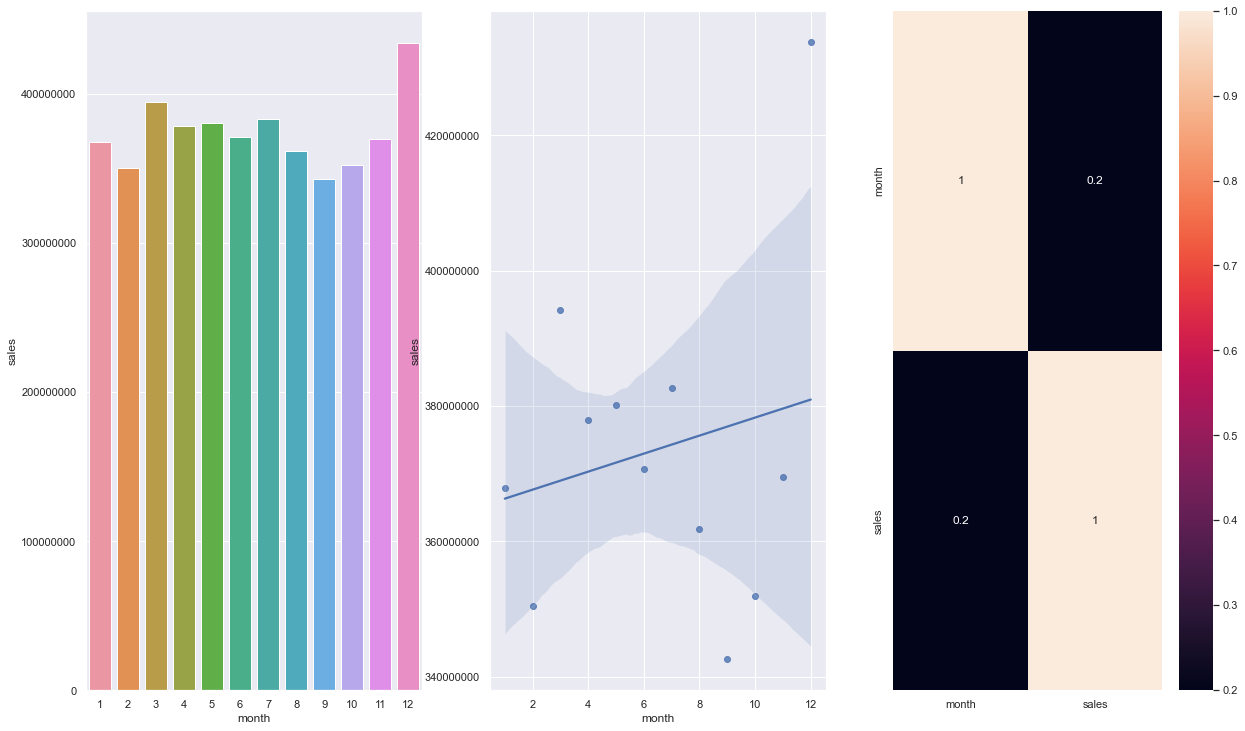

In [157]:
aux1 = df4[df4['year']<2015]
aux1= aux1[['month', 'sales']].groupby( 'month' ).sum().reset_index()

plt.subplot( 1, 3, 1)
sns.barplot( x='month', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='month', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );
plt.gcf().set_size_inches(20.5,12.5)

### H11 Stores should sell more after the 10th of each month.
###  **TRUE** Stores sell more after the 10th of each month.

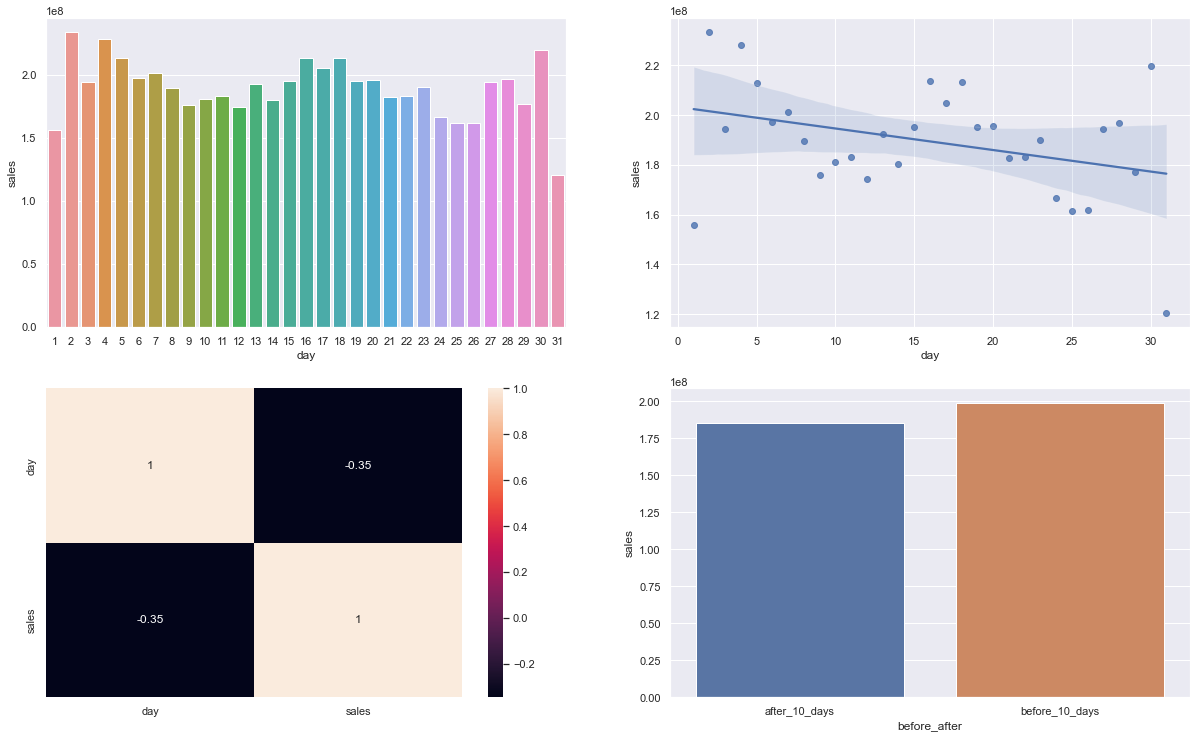

In [146]:
aux1 = df4[['day', 'sales']].groupby( 'day' ).sum().reset_index()

plt.subplot( 2, 2, 1)
sns.barplot( x='day', y='sales', data=aux1 );
plt.ticklabel_format(style='plain', useOffset=False)


plt.subplot( 2, 2, 2 )
sns.regplot( x='day', y='sales', data=aux1 );

plt.subplot( 2, 2, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );
plt.gcf().set_size_inches(20.5,12.5)


plt.subplot( 2, 2, 4)
aux1['before_after']= np.where(aux1['day']<10,'before_10_days','after_10_days')
aux2=aux1[['before_after','sales']].groupby( 'before_after').mean().reset_index()
sns.barplot(x='before_after',y='sales',data=aux2);

### H12 Stores should sell less on weekends.
###  **TRUE** Stores sell less after on weekeds.

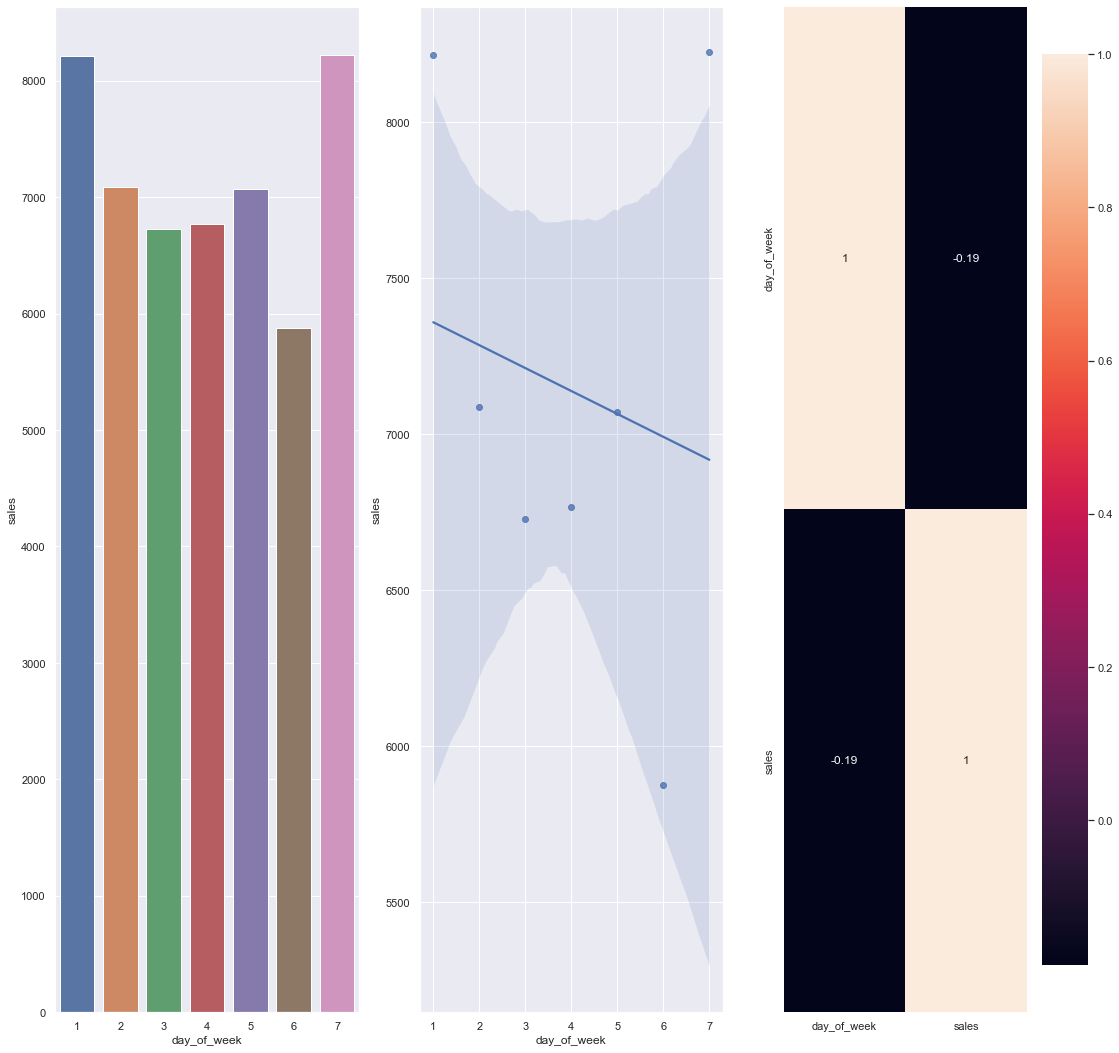

In [165]:
aux1 = df4[['day_of_week', 'sales']].groupby( 'day_of_week' ).mean().reset_index()

plt.subplot( 1, 3, 1)
sns.barplot( x='day_of_week', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='day_of_week', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );
plt.gcf().set_size_inches(18.5,18.5)

### H13 Stores should sell less during school holidays.
###  **TRUE** Stores sell less during school holidays, expect on July and August

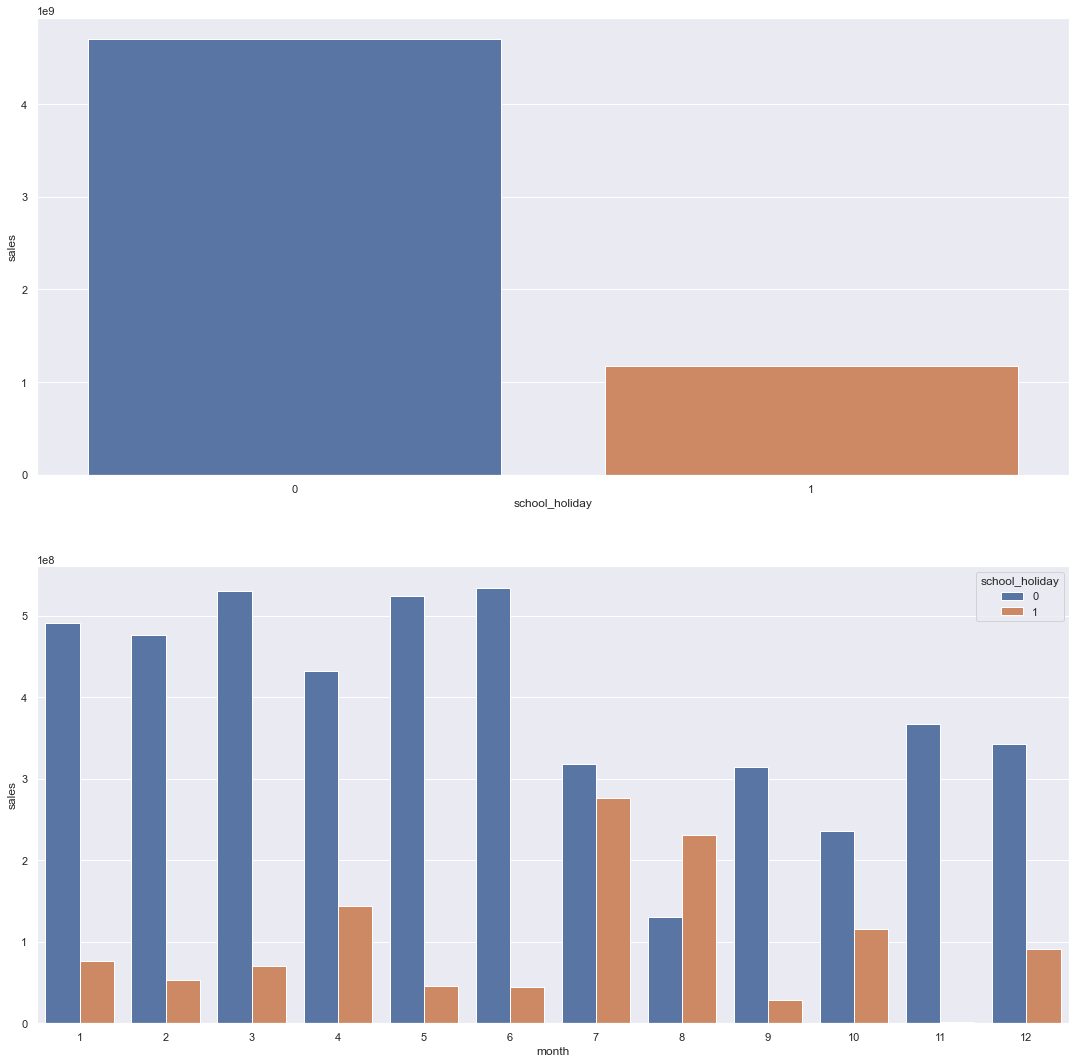

In [42]:
aux1 = df4[['school_holiday', 'sales']].groupby( 'school_holiday' ).sum().reset_index()
plt.subplot( 2, 1, 1 )
sns.barplot( x='school_holiday', y='sales', data=aux1 );

aux2 = df4[['month', 'school_holiday', 'sales']].groupby( ['month','school_holiday'] ).sum().reset_index()
plt.subplot( 2, 1, 2 )
sns.barplot( x='month', y='sales', hue='school_holiday', data=aux2 );
plt.gcf().set_size_inches(18.5,18.5)

## hypoteses summary

In [33]:
hyp=[
["Stores with larger assortments should SELL MORE.",False,'Low'],
["Stores with closer competitors should SELL LESS.",False,'Medium'],
["Stores with longer competitors should SELL MORE.",False,'Medium'],
["Stores with longer active promotions should SELL MORE.",False,'Low'],
["Stores with more agressive promotions ( bigger discounts)  should SELL MORE ", 'Not tested yet','N/A'],
["Stores with more promotion days should SELL MORE.", 'Not tested yet','N/A'],
["Stores with more consecutive promotions should SELL MORE.",False,'Low'],
["Stores open on the Christmas holiday should SELL MORE.",False,'Medium'],
["Stores should SELL MORE over the years.",False,'High'],
["Stores should SELL MORE in the second half of the year.",False,'High'],
["Stores should SELL MORE after the 10th of each month.",True, 'High'],
["Stores should SELL LESS on weekends.",True, 'High'],
["Stores should SELL LESS during school holidays.",True,'Low']
]
summary=pd.DataFrame(hyp,columns=['Hipothesis', 'Conclusion', "Relevance"])
summary

,Hipothesis,Conclusion,Relevance
0,Stores with larger assortments should SELL MORE.,False,Low
1,Stores with closer competitors should SELL LESS.,False,Medium
2,Stores with longer competitors should SELL MORE.,False,Medium
3,Stores with longer active promotions should SE...,False,Low
4,Stores with more agressive promotions ( bigger...,Not tested yet,N/A
5,Stores with more promotion days should SELL MORE.,Not tested yet,N/A
6,Stores with more consecutive promotions should...,False,Low
7,Stores open on the Christmas holiday should SE...,False,Medium
8,Stores should SELL MORE over the years.,False,High
9,Stores should SELL MORE in the second half of ...,False,High


## 4.3 multivariate analysis

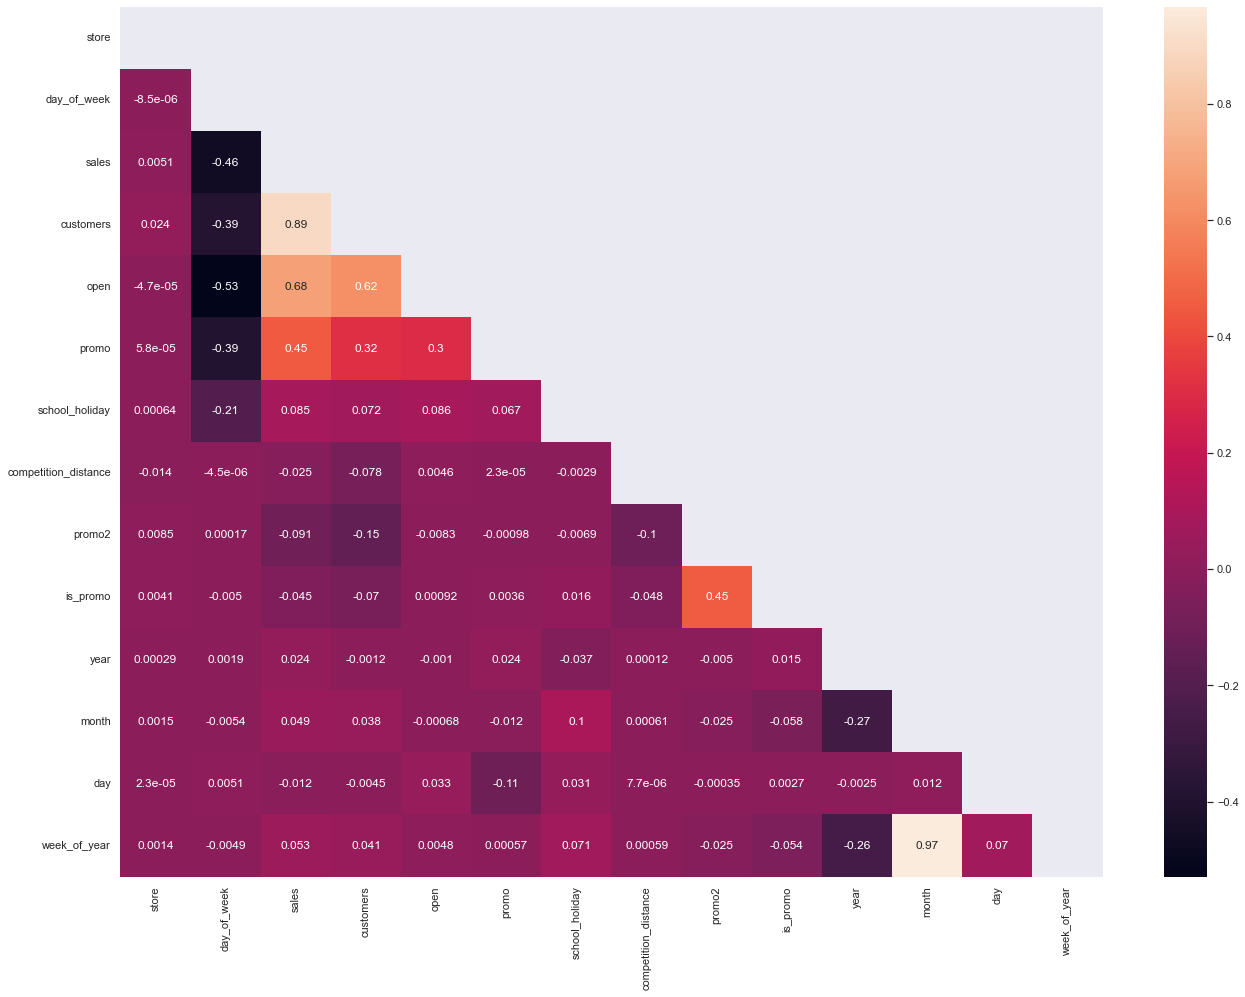

In [44]:
corrs= df2.select_dtypes(include=['float64','int64']).corr(method='pearson')
matrix = np.triu(corrs)
sns.heatmap(corrs,annot=True,mask=matrix)
plt.gcf().set_size_inches(22,16)

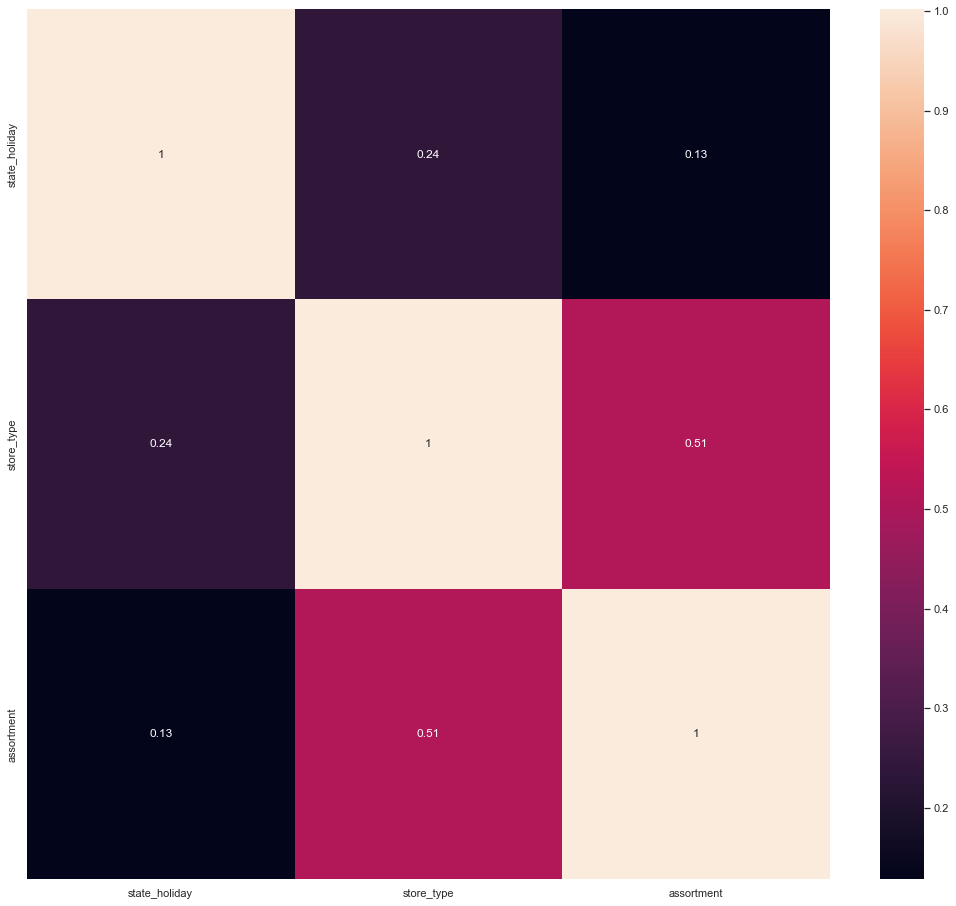

In [45]:
# Calculate cramer V
a1 = cramer_v( a['state_holiday'], a['state_holiday'] )
a2 = cramer_v( a['state_holiday'], a['store_type'] )
a3 = cramer_v( a['state_holiday'], a['assortment'] )

a4 = cramer_v( a['store_type'], a['state_holiday'] )
a5 = cramer_v( a['store_type'], a['store_type'] )
a6 = cramer_v( a['store_type'], a['assortment'] )

a7 = cramer_v( a['assortment'], a['state_holiday'] )
a8 = cramer_v( a['assortment'], a['store_type'] )
a9 = cramer_v( a['assortment'], a['assortment'] )

# Final dataset
d = pd.DataFrame( {'state_holiday': [a1, a2, a3], 
               'store_type': [a4, a5, a6],
               'assortment': [a7, a8, a9]  })
d = d.set_index( d.columns )

sns.heatmap( d, annot=True )
plt.gcf().set_size_inches(18,16)

# 5.0 DATA PREPARATION

In [32]:
df5=df4.copy()

## 5.1 normalization

## 5.2 rescalling

p:\Anaconda3\envs\automl\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
p:\Anaconda3\envs\automl\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
p:\Anaconda3\envs\automl\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
p:\Anaconda3\envs\automl\lib\si

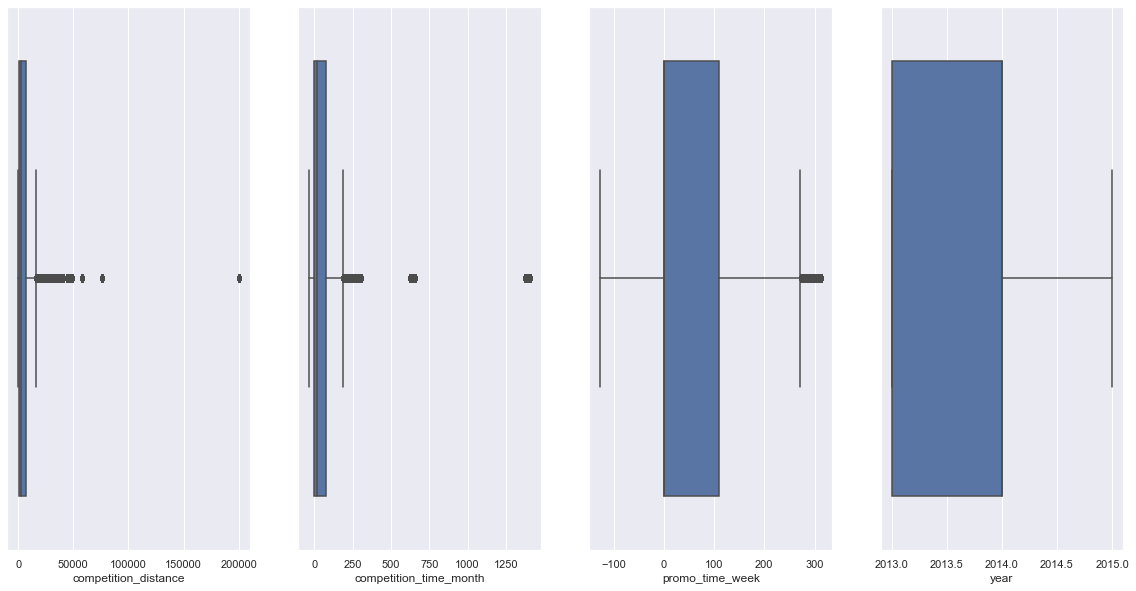

In [33]:
plt.subplot(1,4,1)
sns.boxplot(df4['competition_distance'])
plt.subplot(1,4,2)
sns.boxplot(df4['competition_time_month'])
plt.subplot(1,4,3)
sns.boxplot(df4['promo_time_week'])
plt.subplot(1,4,4)
sns.boxplot(df4['year'])
plt.gcf().set_size_inches(20,10)


In [34]:
rs = RobustScaler()
mms = MinMaxScaler()

os.makedirs("parameters",exist_ok=True)

# competition distance
df5['competition_distance'] = rs.fit_transform( df5[['competition_distance']].values )
#pickle.dump( rs, open( 'parameters/competition_distance_scaler.pkl', 'wb') )

# competition time month
df5['competition_time_month'] = rs.fit_transform( df5[['competition_time_month']].values )
#pickle.dump( rs, open( 'parameters/competition_time_month_scaler.pkl', 'wb') )

# promo time week
df5['promo_time_week'] = mms.fit_transform( df5[['promo_time_week']].values )
#pickle.dump( rs, open( 'parameters/promo_time_week_scaler.pkl', 'wb') )

# year
df5['year'] = mms.fit_transform( df5[['year']].values )
#pickle.dump( mms, open( 'parameters/year_scaler.pkl', 'wb') )

p:\Anaconda3\envs\automl\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
p:\Anaconda3\envs\automl\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
p:\Anaconda3\envs\automl\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

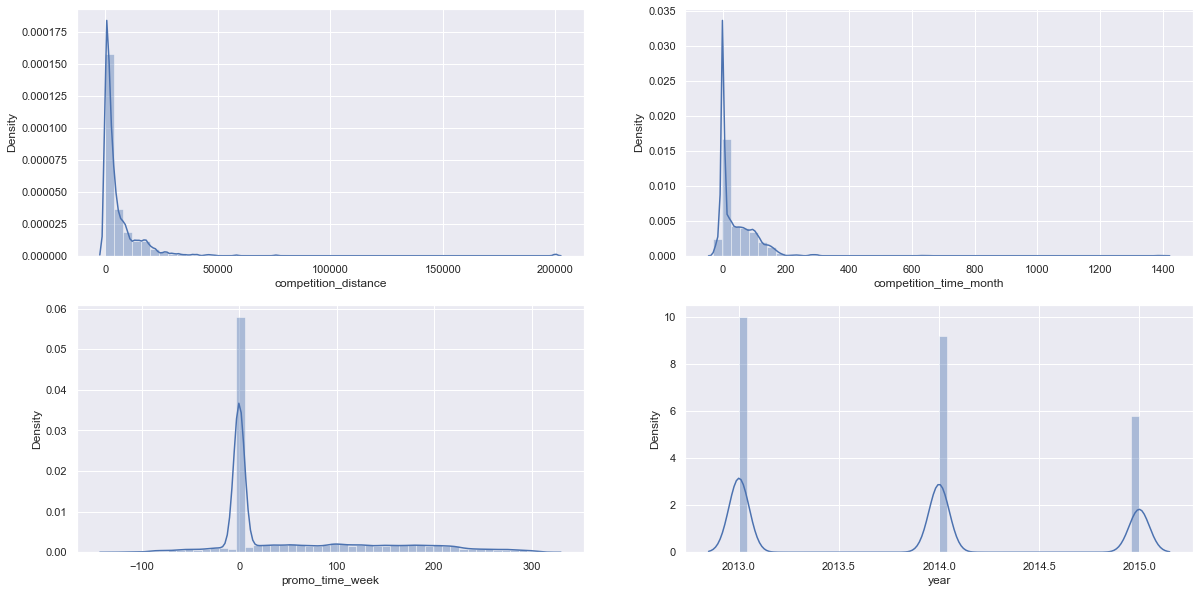

In [35]:
plt.subplot(2,2,1)
sns.distplot(df4['competition_distance'])
plt.subplot(2,2,2)
sns.distplot(df4['competition_time_month'])
plt.subplot(2,2,3)
sns.distplot(df4['promo_time_week'])
plt.subplot(2,2,4)
sns.distplot(df4['year'])
plt.gcf().set_size_inches(20,10)

## 5.3 encoding

In [36]:
#One Hot Encoding

df5=pd.get_dummies(df5,prefix=['state_holiday'],columns=['state_holiday'])

#LabelEncoder
le=LabelEncoder()
df5['store_type']=le.fit_transform(df5['store_type'])
pickle.dump(le,open("parameters/store_type_scaler.pkl","wb"))

#Ordinal Encoder
assortment_dict = {'basic':1 , "extra": 2, "extended":3}
df5['assortment'] = df5['assortment'].map(assortment_dict)
#pickle.dump(rs,open("parameters/assortment_encoder.pkl","wb"))

df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day
0,1,5,2015-07-31,5263,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1
1,2,5,2015-07-31,6064,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1
2,3,5,2015-07-31,8314,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1
3,4,5,2015-07-31,13995,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1
4,5,5,2015-07-31,4822,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1


##  5.4 target variable transformation

## 5.5 nature transformation

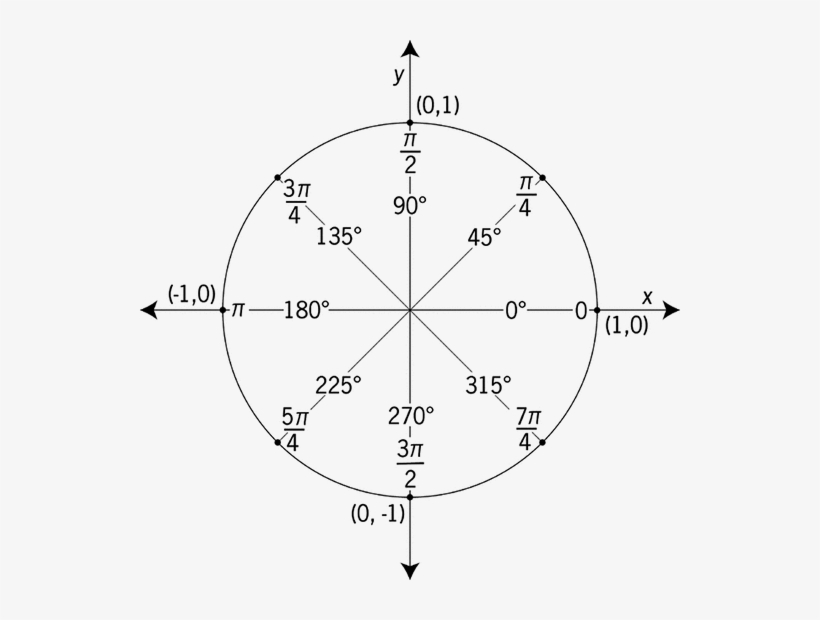

In [37]:
Image('img/trig.png')

In [38]:
# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )

# month
df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )

# day 
df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2. * np.pi/52 ) ) )

# 6.0  FEATURE SELECTION

## 6.1 Split dataframe into training and test dataset

In [39]:
df6=df5.copy()

In [42]:
#save dataframe as parquet
df6.to_csv("df6_final.csv")


In [43]:
# These columns was transformed and assigned to other columns, therefore it won't be used anymore
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week']
df6= df6.drop(cols_drop, axis=1)

In [44]:
df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days=6*7)

Timestamp('2015-06-19 00:00:00')

In [45]:
#Out-of-time split
train= df6[df6['date']<'2015-06-19']
test = df6[df6['date']>='2015-06-19']

xtrain, ytrain = train.drop(['sales'],axis=1), train['sales']
xtest, ytest = test.drop(['sales'], axis=1), test['sales']

print(f"Train size: {xtrain.shape}, {xtrain['date'].max()} \n",
    f"Test size: {xtest.shape}, {xtest['date'].min()}")

Train size: (802942, 28), 2015-06-18 00:00:00 
 Test size: (41396, 28), 2015-06-19 00:00:00


## 6.2 Boruta as Feature Selector

## 6.3 Manual Feature Selection

In [46]:
cols_selected_boruta = [
    'store',
    'promo',
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2',
    'promo2_since_week',
    'promo2_since_year',
    'competition_time_month',
    'promo_time_week',
    'day_of_week_sin',
    'day_of_week_cos',
    'month_sin',
    'month_cos',
    'day_sin',
    'day_cos',
    'week_of_year_sin',
    'week_of_year_cos']
len(cols_selected_boruta)

20

In [47]:
cols_selected_boruta = [
    'store',
    'promo',
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2',
    'promo2_since_week',
    'promo2_since_year',
    'competition_time_month',
    'promo_time_week',
    'day_of_week_sin',
    'day_of_week_cos',
    'month_sin',
    'month_cos',
    'day_sin',
    'day_cos',
    'week_of_year_sin',
    'week_of_year_cos']

# columns to add
feat_to_add = ['date', 'sales']

cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add )

# 7.0 MACHINE LEARNING MODELING

In [48]:
xtrain=train[cols_selected_boruta]
xtest=test[cols_selected_boruta]
xtrainfull=train[cols_selected_boruta_full]

## 7.1 Average Model

In [46]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)


aux1 = xtest.copy()
aux1['sales'] = ytest.copy()

# prediction
aux2 = aux1[['store', 'sales']].groupby( 'store' ).mean().reset_index().rename( columns={'sales': 'predictions'} )
aux1 = pd.merge( aux1, aux2, how='left', on='store' )
ypred_baseline = aux1['predictions']

# performance
baseline_result = errors_ml(aux1['sales'],ypred_baseline,model_name='average_model')
baseline_result

,model_name,MAE,MAPE,MSE,RMSE
0,average_model,1370.96110,0.21699,3304205.88470,1817.74748


## 7.2 Linear Regression Model

In [290]:
# model

...
# define the target transform wrapper


lr=LinearRegression()
wrapped_lr = TransformedTargetRegressor(regressor=lr, func=np.log1p,inverse_func=np.expm1)

# prediction
wrapped_lr.fit( xtrain, ytrain )
ypred_lr = wrapped_lr.predict( xtest )


# performance
lr_result = errors_ml(ytest, ypred_lr,model_name=lr.__class__.__name__)
lr_result

,model_name,MAE,MAPE,MSE,RMSE
0,LinearRegression,1867.08977,0.29269,7134503.90969,2671.04922


## 7.3 Linear Regression Model - Cross Validation

In [291]:
lr_result_cv = cross_validation( xtrainfull, 5, 'Linear Regression', wrapped_lr, verbose=False )
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37


## 7.4 Lasso Regression Model

In [283]:
# model
lrr = Lasso( alpha=0.01 ).fit( xtrain, ytrain )

# prediction
wrapped_lasso = TransformedTargetRegressor(regressor=lrr, func=np.log1p,inverse_func=np.expm1)

# prediction
wrapped_lasso.fit( xtrain, ytrain )
ypred_lrr = wrapped_lasso.predict( xtest )

# performance
lrr_result = errors_ml(ytest, ypred_lrr,model_name=lrr.__class__.__name__)
lrr_result

p:\Anaconda3\envs\kaggle\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.975e+11, tolerance: 7.750e+08
  model = cd_fast.enet_coordinate_descent(


,model_name,MAE,MAPE,MSE,RMSE
0,Lasso,1891.70488,0.28911,7532015.33699,2744.45174


## 7.5 Lasso Regression Model - Cross Validation

In [284]:
lrr_result_cv = cross_validation( xtrainfull, 5, 'Lasso Regression', wrapped_lasso, verbose=False )
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso Regression,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26


## 7.6 Random Forest Regressor

In [275]:
# model
rf = RandomForestRegressor(n_estimators=15, n_jobs=-1,  max_depth=25, random_state=42).fit( xtrain, ytrain )


wrapped_rf = TransformedTargetRegressor(regressor=rf, func=np.log1p,inverse_func=np.expm1)

# prediction
wrapped_rf.fit( xtrain, ytrain )
ypred_rf = wrapped_rf.predict( xtest )

# performance
rf_result = errors_ml(ytest, ypred_rf,model_name=rf.__class__.__name__)
rf_result

,model_name,MAE,MAPE,MSE,RMSE
0,RandomForestRegressor,733.13469,0.10679,1194321.76834,1092.85030


In [277]:
rf_result_cv = cross_validation( xtrainfull, 5, rf.__class__.__name__, wrapped_rf, verbose=False )
rf_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,RandomForestRegressor,901.15 +/- 219.98,0.12 +/- 0.02,1349.91 +/- 317.15


## 7.7 XGBoost Regressor

In [59]:
#model
xgbr = xgb.XGBRegressor(colsample_bytree=0.6,gamma=0.3,learning_rate=0.1,max_depth=15,
min_child_weight=3,subsample=0.9,n_estimators=50,eval_metric='rmse',random_state=42).fit( xtrain, ytrain )

wrapped_xgbr = TransformedTargetRegressor(regressor=xgbr, func=np.log1p,inverse_func=np.expm1)

#prediction
wrapped_xgbr.fit( xtrain, ytrain )
ypred_xgbr = wrapped_xgbr.predict( xtest )


# pemodel_performance
xgbr_result = errors_ml(ytest, ypred_xgbr,model_name=xgbr.__class__.__name__)
xgbr_result

,model_name,MAE,MAPE,MSE,RMSE
0,XGBRegressor,940.36205,0.12634,1981111.28621,1407.51955


## 7.8 XGBoost Regressor CrossValidation

In [60]:
xgbr_result_cv = cross_validation( xtrainfull, 5, xgbr.__class__.__name__, wrapped_xgbr, verbose=False )
xgbr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBRegressor,1158.34 +/- 223.18,0.15 +/- 0.02,1691.34 +/- 333.91


## 7.9 Compare Initial Models Performance

In [ ]:
modelling_result=pd.concat([baseline_result,lr_result,lrr_result,rf_result,xgbr_result])
modelling_result.sort_values("rmse")

,model_name,mae,mape,mse,rmse
0,RandomForestRegressor,733.13469,0.10679,1194321.76834,1092.85030
0,XGBRegressor,940.36205,0.12634,1981111.28621,1407.51955
0,average_model,1354.80035,0.20640,3367722.45872,1835.13554
0,LinearRegression,1867.08977,0.29269,7134503.90969,2671.04922
0,Lasso,1891.70488,0.28911,7532015.33699,2744.45174


## 7.10 Compare Cross Validation Performance

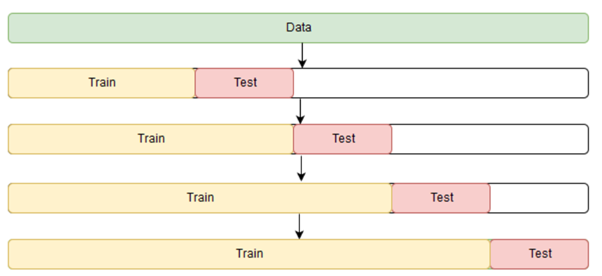

In [293]:
Image('img/cv.png')

In [292]:
model_results_cv = pd.concat([lr_result_cv,lrr_result_cv,rf_result_cv,xgbr_result_cv])
model_results_cv.sort_values('RMSE CV')

,Model Name,MAE CV,MAPE CV,RMSE CV
0,RandomForestRegressor,901.15 +/- 219.98,0.12 +/- 0.02,1349.91 +/- 317.15
0,XGBRegressor,1158.34 +/- 223.18,0.15 +/- 0.02,1691.34 +/- 333.91
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37
0,Lasso Regression,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26


# 8.0 FINAL MODEL | FINETUNING

In [47]:
params = {"colsample_bytree":[ 0.7, 0.9],
"learning_rate": [0.1],
"max_depth":[10,15,20],
"min_child_weight":[2,3,4], 
"subsample": [ 0.7,0.9],
"gamma": [0.3,0.4],
"n_estimators":[50,75],
"eval_metric":['rmse'],
"random_state":[42]}

In [49]:
final_result = pd.DataFrame()
MAX_EVAL=4
for i in range(MAX_EVAL):
   # choose values for parameters randomly
   hp = { k: np.random.choice(params[k] , 1)[0] for k, v in params.items() }
   print( hp )
   
   # model
   xgbr_t = xgb.XGBRegressor(
                                 n_estimators=hp['n_estimators'], 
                                 max_depth=hp['max_depth'], 
                                 subsample=hp['subsample'],
                                 colsample_bytee=hp['colsample_bytree'],
                                 min_child_weight=hp['min_child_weight'],
                                 learning_rate=hp['learning_rate'],
                                 random_state=hp['random_state'],
                                 eval_metric=hp['eval_metric'])

   # performance

   wrapped_xgbr = TransformedTargetRegressor(regressor=xgbr_t, func=np.log1p,inverse_func=np.expm1)


   result = cross_validation( train, 5 ,xgbr_t.__class__.__name__ , wrapped_xgbr ,verbose=True )
   final_result = pd.concat( [final_result, result] )
       
final_result 

{'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 10, 'min_child_weight': 4, 'subsample': 0.9, 'gamma': 0.4, 'n_estimators': 50, 'eval_metric': 'rmse', 'random_state': 42}

KFold Number: 5
[06:10:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "colsample_bytee" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.



KFold Number: 4
[06:10:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "colsample_bytee" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged 

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBRegressor,1402.78 +/- 200.01,0.18 +/- 0.02,2030.61 +/- 274.2
0,XGBRegressor,941.45 +/- 192.73,0.13 +/- 0.02,1360.26 +/- 280.29
0,XGBRegressor,1157.09 +/- 176.27,0.16 +/- 0.02,1665.36 +/- 239.21
0,XGBRegressor,1041.93 +/- 159.51,0.14 +/- 0.01,1503.07 +/- 234.37


## 8.1 Final Model

In [49]:
param_tuned= {"objective" : 'reg:squarederror','colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 10, 'min_child_weight': 2, 'subsample': 0.9, 'gamma': 0.4, 'n_estimators': 75, 'eval_metric': 'rmse', 'random_state': 42}

## 8.2 Hyperparameter Tuning and Cross Validation

In [50]:
# model
xgbr_tf = xgb.XGBRegressor(objective=param_tuned['objective'],
                                    n_estimators=param_tuned['n_estimators'], 
                                    eval_metric=param_tuned['eval_metric'],
                                    learning_rate=param_tuned['learning_rate'],
                                    max_depth=param_tuned['max_depth'], 
                                    subsample=param_tuned['subsample'],
                                    colsample_bytee=param_tuned['colsample_bytree'],
                                    min_child_weight=param_tuned['min_child_weight'],
                                    random_state=param_tuned['random_state'],
                                    gamma=param_tuned['gamma'])

# performance

wrapped_xgbr_f = TransformedTargetRegressor(regressor=xgbr_tf, func=np.log1p,inverse_func=np.expm1)


result = cross_validation( xtrainfull , 5 ,xgbr_tf.__class__.__name__ , wrapped_xgbr_f ,verbose=False )
result

p:\Anaconda3\envs\automl\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[06:11:39] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:576: 
Parameters: { "colsample_bytee" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




p:\Anaconda3\envs\automl\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[06:12:17] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:576: 
Parameters: { "colsample_bytee" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




p:\Anaconda3\envs\automl\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[06:12:57] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:576: 
Parameters: { "colsample_bytee" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




p:\Anaconda3\envs\automl\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[06:13:39] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:576: 
Parameters: { "colsample_bytee" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




p:\Anaconda3\envs\automl\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[06:14:30] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:576: 
Parameters: { "colsample_bytee" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBRegressor,1158.0 +/- 186.79,0.16 +/- 0.02,1669.75 +/- 252.09


## 8.3 Final evaluation

In [53]:
# model
model_xgb_tuned = xgb.XGBRegressor( objective='reg:squarederror',
                                    n_estimators=param_tuned['n_estimators'], 
                                    eval_metric=param_tuned['eval_metric'],
                                    learning_rate=param_tuned['learning_rate'],
                                    max_depth=param_tuned['max_depth'], 
                                    subsample=param_tuned['subsample'],
                                    colsample_bytee=param_tuned['colsample_bytree'],
                                    min_child_weight=param_tuned['min_child_weight'],
                                    random_state=param_tuned['random_state'],
                                    gamma=param_tuned['gamma']).fit( xtrain, ytrain )

# prediction
ypred_xgb_tuned = model_xgb_tuned.predict(xtest)

# performance
xgb_result_tuned = errors_ml(ytrue=ytest,ypred=ypred_xgb_tuned,model_name=model_xgb_tuned.__class__.__name__)
xgb_result_tuned

p:\Anaconda3\envs\automl\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[06:17:41] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:576: 
Parameters: { "colsample_bytee" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




,model_name,MAE,MAPE,MSE,RMSE
0,XGBRegressor,955.425947,0.150809,1.772510e+06,1331.35636


In [54]:
def mean_percentage_error (y, ypred):
    return np.mean((y - ypred)/y )

In [80]:
mpe = mean_absolute_percentage_error(  (ytest), (ypred_xgb_tuned))
mpe

0.15080866571121057

## 8.4 Serialize model

In [11]:
#pickle.dump( model_xgb_tuned, open( r'parameters/model_xgb_rossmann_v0.pkl', 'wb') )
model_xgb_tuned=pickle.load( open( r'parameters/model_xgb_rossmann_v0.pkl', 'rb') )

# 9.0 ERROR INTERPRETATION TO BUSINESS

In [83]:
df9 = test[cols_selected_boruta_full]

df9['predictions']= ypred_xgb_tuned


C:\Users\kosmo\AppData\Local\Temp\ipykernel_2832\981885350.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['predictions']= ypred_xgb_tuned


## 9.1 business performance

In [84]:
# sum of predictions
df91 = df9[['store', 'predictions']].groupby( 'store' ).sum().reset_index()

# MAE and MAPE
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby( 'store' ).apply( lambda x: mean_absolute_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAE'})
df9_aux2 = df9[['store', 'sales', 'predictions']].groupby( 'store' ).apply( lambda x: mean_absolute_percentage_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAPE'})

# Merge
df9_aux3 = pd.merge( df9_aux1, df9_aux2, how='inner', on='store' )
df92 = pd.merge( df91, df9_aux3, how='inner', on='store' )

# Scenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

# order columns
df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

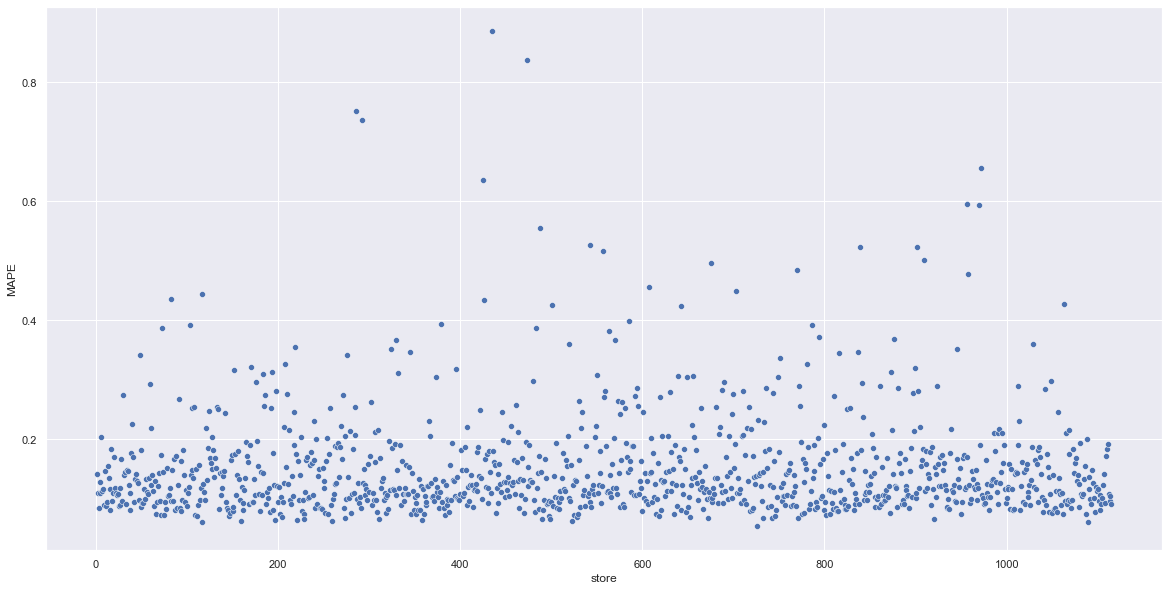

In [85]:
sns.scatterplot(x='store',y='MAPE',data=df92)
plt.gcf().set_size_inches(20,10)

In [117]:
df92.sort_values( 'MAPE', ascending=False ).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,108004.476562,104526.588045,111482.365080,3477.888518,0.607484
285,286,200882.500000,199140.999861,202624.000139,1741.500139,0.579340
908,909,210816.875000,202553.809273,219079.940727,8263.065727,0.537270
434,435,164331.343750,162880.793708,165781.893792,1450.550042,0.501755
955,956,155651.453125,154510.889794,156792.016456,1140.563331,0.420054


## 9.2 total performance

In [118]:
df93=df92[['predictions','worst_scenario','best_scenario']].apply(lambda x: np.sum(x),axis=0).reset_index().rename(columns={'index':'Scenario',0:'Values'})
df93['Values']=df93['Values'].map( 'R${:,.2f}'.format )
df93

,Scenario,Values
0,predictions,"R$280,252,224.00"
1,worst_scenario,"R$279,290,658.09"
2,best_scenario,"R$281,213,783.39"


## 9.3 machine learning performance

In [119]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

C:\Users\kosmo\AppData\Local\Temp\ipykernel_8856\1385645114.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['error'] = df9['sales'] - df9['predictions']
C:\Users\kosmo\AppData\Local\Temp\ipykernel_8856\1385645114.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['error_rate'] = df9['predictions'] / df9['sales']


p:\Anaconda3\envs\kaggle\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
p:\Anaconda3\envs\kaggle\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


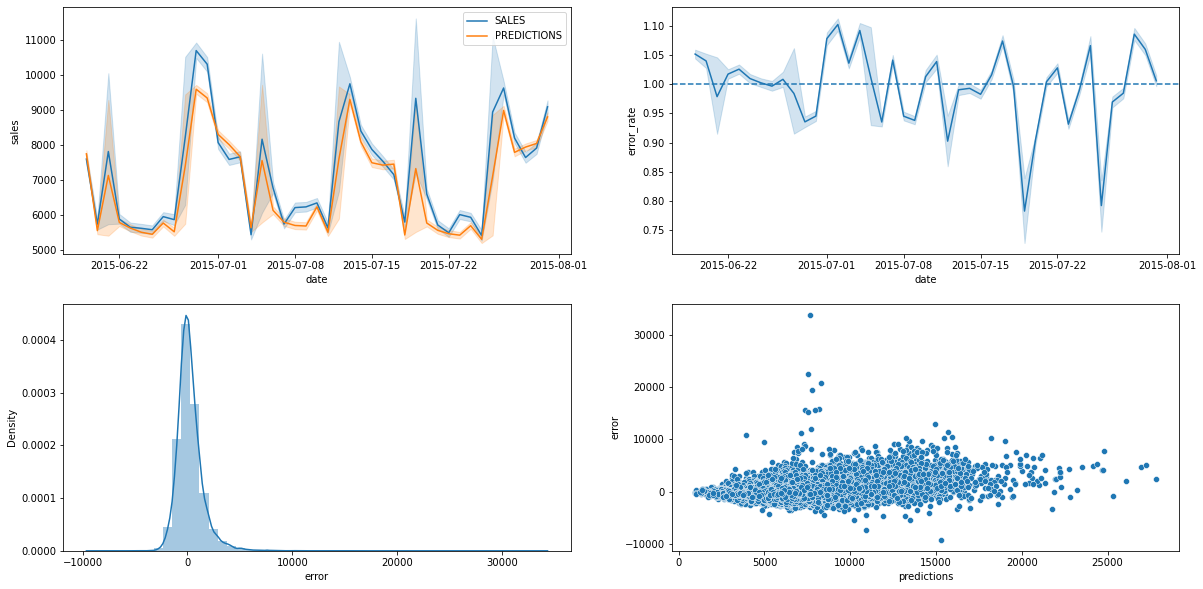

In [121]:
plt.subplot( 2, 2, 1 )
sns.lineplot( x='date', y='sales', data=df9, label='SALES' )
sns.lineplot( x='date', y='predictions', data=df9, label='PREDICTIONS' )

plt.subplot( 2, 2, 2 )
sns.lineplot( x='date', y='error_rate', data=df9 )
plt.axhline( 1, linestyle='--')

plt.subplot( 2, 2, 3 )
sns.distplot( df9['error'] )

plt.subplot( 2, 2, 4 )
sns.scatterplot( df9['predictions'], df9['error'] )
plt.gcf().set_size_inches(20,10)

# 10.0 DEPLOY MODEL TO PRODUCTION

## 10.1 Rossmann class

In [86]:
import pickle
import inflection
import pandas as pd
import numpy as np
import math
import datetime

class Rossmann( object ):
    def __init__( self ):
        self.home_path='P:\Python\GitHub\forecast_sales'
        self.competition_distance_scaler   = pickle.load( open( self.home_path + '\parameters\competition_distance_scaler.pkl', 'rb') )
        self.competition_time_month_scaler = pickle.load( open( self.home_path + '\parameters\competition_time_month_scaler.pkl', 'rb') )
        self.promo_time_week_scaler        = pickle.load( open( self.home_path + '\parameters\promo_time_week_scaler.pkl', 'rb') )
        self.year_scaler                   = pickle.load( open( self.home_path + '\parameters\year_scaler.pkl', 'rb') )
        self.store_type_scaler             = pickle.load( open( self.home_path + '\parameters\store_type_scaler.pkl', 'rb') )
        
        
    def data_cleaning( self, df1 ): 
        
        ## 1.1. Rename Columns
        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 
                    'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
                    'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

        snakecase = lambda x: inflection.underscore( x )

        cols_new = list( map( snakecase, cols_old ) )

        # rename
        df1.columns = cols_new

        ## 1.3. Data Types
        df1['date'] = pd.to_datetime( df1['date'] )

      
        #fillna competition_distance        
        df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan( x ) else x )

        #competition_open_since_month
        df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1 )

        #competition_open_since_year 
        df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1 )

        #promo2_since_week           
        df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1 )

        #promo2_since_year           
        df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1 )

        #promo_interval              
        month_map = {1: 'Jan',  2: 'Fev',  3: 'Mar',  4: 'Apr',  5: 'May',  6: 'Jun',  7: 'Jul',  8: 'Aug',  9: 'Sep',  10: 'Oct', 11: 'Nov', 12: 'Dec'}

        df1['promo_interval'].fillna(0, inplace=True )

        df1['month_map'] = df1['date'].dt.month.map( month_map )

        df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 )

        # change data type competiton
        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int )

        # change data type promo2
        df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )
        df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )
        
        return df1 


    def feature_engineering( self, df2 ):

        # year
        df2['year'] = df2['date'].dt.year

        # month
        df2['month'] = df2['date'].dt.month

        # day
        df2['day'] = df2['date'].dt.day

        # week of year
        df2['week_of_year'] = df2['date'].dt.weekofyear

        # year week
        df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

        # competition since
        df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'],day=1 ), axis=1 )
        df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30 ).apply( lambda x: x.days ).astype( int )

        # promo since
        df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
        df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
        df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days ).astype( int )

        # assortment
        df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

        # state holiday
        df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )

     
        # row filtering
        df2 = df2[df2['open'] != 0]

        # col filtering
        cols_drop = ['open', 'promo_interval', 'month_map']
        df2 = df2.drop( cols_drop, axis=1 )
        
        return df2


    def data_preparation( self, df5 ):

        ## 5.2. Rescaling 
        # competition distance
        df5['competition_distance'] = self.competition_distance_scaler.transform( df5[['competition_distance']].values )
    
        # competition time month
        df5['competition_time_month'] = self.competition_time_month_scaler.transform( df5[['competition_time_month']].values )

        # promo time week
        df5['promo_time_week'] = self.promo_time_week_scaler.transform( df5[['promo_time_week']].values )
        
        # year
        df5['year'] = self.year_scaler.transform( df5[['year']].values )

        ### 5.3.1. Encoding
        # state_holiday - One Hot Encoding
        df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'] )

        # store_type - Label Encoding
        df5['store_type'] = self.store_type_scaler.transform( df5['store_type'] )

        # assortment - Ordinal Encoding
        assortment_dict = {'basic': 1,  'extra': 2, 'extended': 3}
        df5['assortment'] = df5['assortment'].map( assortment_dict )

        
        ### 5.3.3. Nature Transformation
        # day of week
        df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
        df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )

        # month
        df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
        df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )

        # day 
        df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
        df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )

        # week of year
        df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
        df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2. * np.pi/52 ) ) )
        
        
        cols_selected = [ 'store', 'promo', 'store_type', 'assortment', 'competition_distance', 'competition_open_since_month',
            'competition_open_since_year', 'promo2', 'promo2_since_week', 'promo2_since_year', 'competition_time_month', 'promo_time_week',
            'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos', 'day_sin', 'day_cos', 'week_of_year_sin', 'week_of_year_cos']
        
        return df5[ cols_selected ]
    
    
    def get_prediction( self, model, original_data, test_data ):
        # prediction
        pred = model.predict( test_data )
        
        # join pred into the original data
        original_data['prediction'] = pred
        
        return original_data.to_json( orient='records', date_format='iso' )

## 10.2 API handler

In [61]:
import pickle
import pandas as pd
from flask             import Flask, request, Response
from google_cloud_run.rossmann import rossmann
import inflection

# loading model
model = pickle.load( open(r'P:/Python/GitHub/forecast_sales/parameters/model_xgb_rossmann_v0.pkl', 'rb') )

# initialize API
app = Flask( __name__ )

@app.route( r'/rossmann/predict', methods=['POST'] )
def rossmann_predict():
    test_json = request.get_json()
   
    if test_json: # there is data
        if isinstance( test_json, dict ): # unique example
            test_raw = pd.DataFrame( test_json, index=[0] )
            
        else: # multiple example
            test_raw = pd.DataFrame( test_json, columns=test_json[0].keys() )
            
        # Instantiate Rossmann class
        pipeline = Rossmann()
        
        # data cleaning
        df1 = pipeline.data_cleaning( test_raw )
        
        # feature engineering
        df2 = pipeline.feature_engineering( df1 )
        
        # data preparation
        df3 = pipeline.data_preparation( df2 )
        
        # prediction
        df_response = pipeline.get_prediction( model, test_raw, df3 )
        
        return df_response
        
        
    else:
        return Response( '{}', status=200, mimetype='application/json' )

if __name__ == '__main__':
    app.run( '192.168.1.1:5555' )

 * Serving Flask app '__main__' (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


The requested address is not valid in its context


AssertionError: 

## 10.3 API tester

In [12]:
#loading test dataset
df10=pd.read_csv(r"data/test.csv")
store=pd.read_csv(r'data/store.csv')
df10.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


In [13]:
# merge test dataset +store
df_test=df10.merge(store,how='left',on='Store')

#choose store for prediction
df_test = df_test[df_test['Store'] == 20]

#remove closed days
df_test=df_test[(df_test['Open']!=0) & (~df_test['Open'].isnull())]


In [14]:
# convert Dataframe to json
import json
import requests
data = json.dumps(df_test.to_dict(orient='records'))

In [33]:
!pip install google.cloud

In [34]:
from google.cloud import storage

storage_client = storage.Client()

ModuleNotFoundError: No module named 'google.cloud'

In [31]:
#API Call
#url = 'http://192.168.1.13:5000/rossmann/predict'
url = "https://getpred-d6n6jku5cq-rj.a.run.app"
data=data

header = {'Content-type':  'application/json','debug':'True'}

r=requests.post(url, data, headers=header)
print( f'Status Code {r.status_code}')

Status Code 503


In [16]:
d1 = pd.DataFrame( r.json(), columns=r.json()[0].keys())

In [17]:
d1.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,prediction
0,14,20,4,2015-09-17,1.0,1,0,0,d,a,2340.0,5.0,2009.0,1,40.0,2014.0,"Jan,Apr,Jul,Oct",7191.051758
1,870,20,3,2015-09-16,1.0,1,0,0,d,a,2340.0,5.0,2009.0,1,40.0,2014.0,"Jan,Apr,Jul,Oct",7222.213379
2,1726,20,2,2015-09-15,1.0,1,0,0,d,a,2340.0,5.0,2009.0,1,40.0,2014.0,"Jan,Apr,Jul,Oct",8024.687988
3,2582,20,1,2015-09-14,1.0,1,0,1,d,a,2340.0,5.0,2009.0,1,40.0,2014.0,"Jan,Apr,Jul,Oct",9349.294922
4,4294,20,6,2015-09-12,1.0,0,0,0,d,a,2340.0,5.0,2009.0,1,40.0,2014.0,"Jan,Apr,Jul,Oct",6913.838379


In [18]:
d2 = d1[['Store', 'prediction']].groupby( 'Store' ).sum().reset_index()

for i in range( len( d2 ) ):
    print( 'Store Number {} will sell R${:,.2f} in the next 6 weeks'.format( 
            d2.loc[i, 'Store'], 
            d2.loc[i, 'prediction'] ) )

Store Number 20 will sell R$292,716.06 in the next 6 weeks
